## Little Case

In [2]:
from lkif import LinearLKInformationFlow
import numpy as np
from tqdm import tqdm
# from causality_subspace import causality_subspace

dt=1
pn=1
T1=[];T2=[]
# pca = PCA(n_components=5)  # 假设我们想将数据降到2维  
Nt=20
np.random.seed(5)
# for i in tqdm(range(100)):
X1=np.random.randn(5,Nt)*0.2
X2=np.random.randn(5,Nt)*0.2

A1=np.array([[0.9,0.6,0,0.6,0],[0,0.8,0.6,0,0.6],[0,0,0.9,0,0],[0,0,0,0.2,0],[0,0,0,0,0.2]]).T
A2=np.array([[0.2,0.6,0,0.6,0],[0,0.2,0.6,0,0.6],[0,0,0.2,0,0],[0,0,0,0.2,0],[0,0,0,0,0.2]]).T

B1=-np.array([[0,0,0,0,0],[0,0.,0,0,0],[0,0,0,0.9,0.],[0,0,0,0.,0],[0,0,0,0,0]])
B2=-np.array([[0,0,0,0,0],[0,0.0,0,0,0],[0,0,0,0,0],[0,0,0,0.4,0],[0,0,0,0,0]])
for it in range(1,Nt):
    X1[:,it]=A1@X1[:,it-1]+X1[:,it]+1*B1@X2[:,it-1] 
    X2[:,it]=A2@X2[:,it-1]+X2[:,it]+1*B2@X1[:,it-1] 
    
XX=np.zeros([10,Nt])
XX[:5]=X1
XX[5:]=X2

In [3]:
## split space intwo several subspaces, 
# e.g. [(0,1),(1,2] means the first subspace is index 0, the second subspace is index 1
# e.g. [(0,5),(5,10)] means the first subspace is index 0-4, the second subspace is index 5-9
segments = [(0, 5),(5,10)]

In [4]:
lkif_linear = LinearLKInformationFlow(1)
lkif_linear.causality_estimate([XX[:,-15000:].T,XX[:,-30000:-15000].T], lag_list=[1], segments=segments)

In [5]:
import numpy as np
from scipy import stats
result_dict = lkif_linear.get_dict()

In [6]:
# 已知参数
sample_mean = result_dict["information_flow"]
pop_mean = 0       # 假设的总体均值
sample_std = result_dict["information_flow_std"]    # 样本标准差
n = 20     # 样本数量

# 计算 t 统计量
t_stat = (sample_mean - pop_mean) / (sample_std / np.sqrt(n))

# 计算 p 值（双侧检验）
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))

print(p_value)

[[1.58983937e-13 9.09644169e-01]
 [7.69628494e-06 0.00000000e+00]]


In [7]:
result_dict["statistics"]["p"]

array([[4.27353731e-05, 9.79483099e-01],
       [1.74490124e-01, 1.26076927e-12]])

In [8]:
lkif_linear.bootstrap_estimate([XX[:,-15000:].T,XX[:,-30000:-15000].T], lag_list=[1], segments=segments)

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

{'bootstrap_information_flow_mean': array([[-3.60850405,  0.37617933],
        [ 0.5352709 , -5.19958261]]),
 'bootstrap_information_flow_std': array([[2.47051546, 2.41601964],
        [3.28916847, 3.32966262]]),
 'bootstrap_information_flow_list': None}

In [9]:
result_dict = lkif_linear.get_dict()

In [10]:
result_dict["information_flow"]

array([[-3.17967721,  0.01261863],
       [ 0.78202179, -5.407303  ]])

In [11]:
result_dict["information_flow"]

array([[-3.17967721,  0.01261863],
       [ 0.78202179, -5.407303  ]])

In [12]:
## significance test
np.abs(result_dict["information_flow"]) > result_dict["statistics"]["p90_critical_value"]

array([[ True, False],
       [False,  True]])

---
---

## Prof. Liang's case
+ There is no information flow between X and Y in fact.
+ The original significance test, using a 90% confidence interval, will show a limited information flow.
+ The modified method, on the other hand, will correctly accept the null hypothesis ($H_0$).

In [14]:
seed = 9
np.random.seed(seed)
dt = 1 # 时间步长
Nt = 100000  # 时间步数
noise_strength = 20
d = 2  # 维度
# 构建系统矩阵 A
A = np.array([[0.5, 0.],
            [0., 0.9],])

# 确定噪声矩阵 B
B = np.eye(d, d) * noise_strength# 适当缩小噪声规模
f = np.array([0., 0.])
# 初始化状态变量
X = np.zeros((d, Nt))
X[:, 0] = np.random.randn(d)  # 初始状态

# 生成数据
for t in tqdm(range(1, Nt)):
    X[:, t] =  dt * (A @ X[:, t-1] +f) + B @ np.random.randn(d) * np.sqrt(dt)

lkif_linear = LinearLKInformationFlow(1)
lkif_linear.causality_estimate([X.T[-50000:]], lag_list=[1])
result_dict = lkif_linear.get_dict()

  0%|          | 0/99999 [00:00<?, ?it/s]

100%|██████████| 99999/99999 [00:02<00:00, 49990.00it/s]


In [15]:
print('## Is there a causal relationship? (False indicates no information flow)\n')
print("### Original variance test")
print("```")
print(np.abs(result_dict["information_flow"]) > result_dict["information_flow_std_origin"] * 1.65)
print("```")

print("### Newly proposed variance test")
print("```")
print(np.abs(result_dict["information_flow"]) > result_dict["information_flow_std"] * 1.65)
print("```")


## Is there a causal relationship? (False indicates no information flow)

### Original variance test
```
[[ True False]
 [ True  True]]
```
### Newly proposed variance test
```
[[ True False]
 [False  True]]
```


Load data

In [16]:
## load data/X.dat and Y.dat
import pandas as pd
data_X = pd.read_csv('data/X.dat', header=None)
data_Y = pd.read_csv('data/Y.dat', header=None)
data_X = data_X.to_numpy()
data_Y = data_Y.to_numpy()

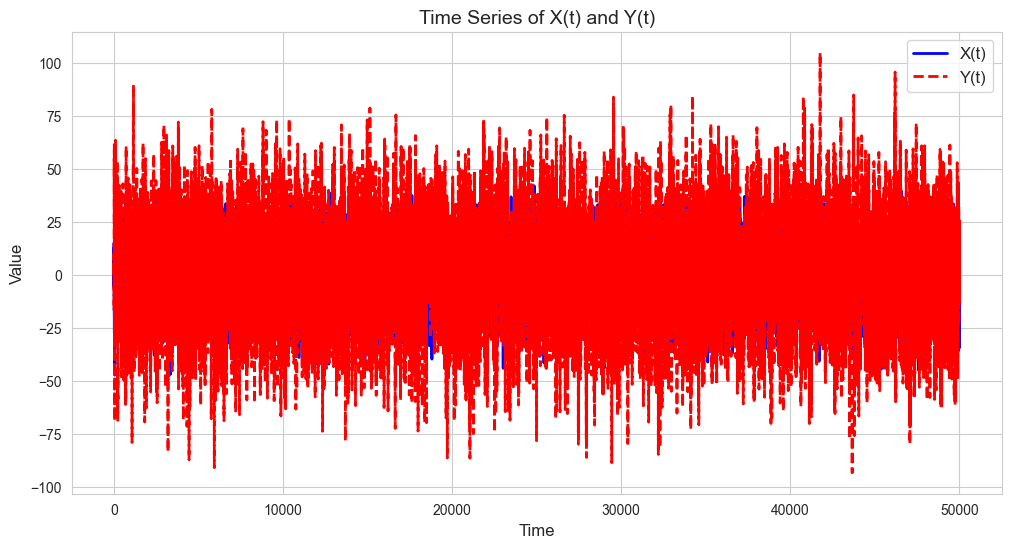

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 风格
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# 绘制时间序列
plt.plot(data_X, label='X(t)', color='b', linewidth=2)
plt.plot(data_Y, label='Y(t)', color='r', linestyle='--', linewidth=2)

# 添加标题和标签
plt.title("Time Series of X(t) and Y(t)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)

# 添加图例
plt.legend(fontsize=12)

# 显示图像
plt.show()


In [18]:
data = np.concatenate((data_X, data_Y), axis=1)

In [19]:
segments = [(0,1),(1,2)]

In [20]:
lkif_linear = LinearLKInformationFlow(1)
lkif_linear.causality_estimate([data], lag_list=[1], segments=segments)

In [21]:
result_dict = lkif_linear.get_dict()

In [22]:
print('## 是否存在因果关系 (False 代表无信息流)\n')
print("### 使用原本的方差检验方法")
print("```")
print(np.abs(result_dict["information_flow"]) > result_dict["information_flow_std_origin"] * 1.65)
print("```")

print("### 使用新的方差检验方法")
print("```")
print(np.abs(result_dict["information_flow"]) > result_dict["information_flow_std"] * 1.65)
print("```")


## 是否存在因果关系 (False 代表无信息流)

### 使用原本的方差检验方法
```
[[ True False]
 [ True  True]]
```
### 使用新的方差检验方法
```
[[ True False]
 [False  True]]
```


---
---
## Bootstrap Method V.S. Significance test Method

In [23]:
import numpy as np
from tqdm import tqdm

noise_strength = 1
np.random.seed(27)

# 调整参数
dt = 1 # 时间步长
Nt = 100000  # 时间步数
d = 6  # 维度
# 构建系统矩阵 A
# A = np.array([[-0.4,  0.4, -0.6,  0.4,  0.2, -0.2],
#        [-0.1, -0.2,  0.4,  0.1, -0.4, -0. ],
#        [ 0.7, -0.5, -0.1, -0.2, -0. ,  0.1],
#        [-0.3, -0.1,  0.2, -0.1,  0.2, -0.3],
#        [-0.2,  0.4,  0.1, -0.2, -0.1, -0.3],
#        [ 0. ,  0.2,  0. ,  0.4,  0.3, -0.2]])
A = np.array([[-0.1, 0., 0., -0.1, 0., -0.3],
              [0.6, -0.2, 0., -0., -0.4, 0.5],
              [0., 0.6, -0.8, 0.1, -0., -0.],
              [-0., 0.1, -0., -0.8, 0., 0.],
              [-0., 0.3, -0.1, 0.6, -0.7, 0.],
              [-0.2, -0., -0.1, 0., 0.6, -0.5]])

# 确定噪声矩阵 B
B = np.random.randn(d, d) * noise_strength# 适当缩小噪声规模
f = np.array([0.1,-0.1,0.1,-0.2,0.2,0.1])
# 初始化状态变量
X = np.zeros((d, Nt))
X[:, 0] = np.random.randn(d)  # 初始状态

# 生成数据
for t in tqdm(range(1, Nt)):
    X[:, t] = X[:, t-1] + dt * (A @ X[:, t-1] +f) + B @ np.random.randn(d) * np.sqrt(dt)

100%|██████████| 99999/99999 [00:03<00:00, 27270.01it/s]


In [25]:
from lkif import LinearLKInformationFlow
import numpy as np
import matplotlib.pyplot as plt

In [26]:
## 去掉对角元素
def remove_diagonal(matrix):
    mask = ~np.eye(matrix.shape[0], dtype=bool)
    return matrix[mask].flatten()

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


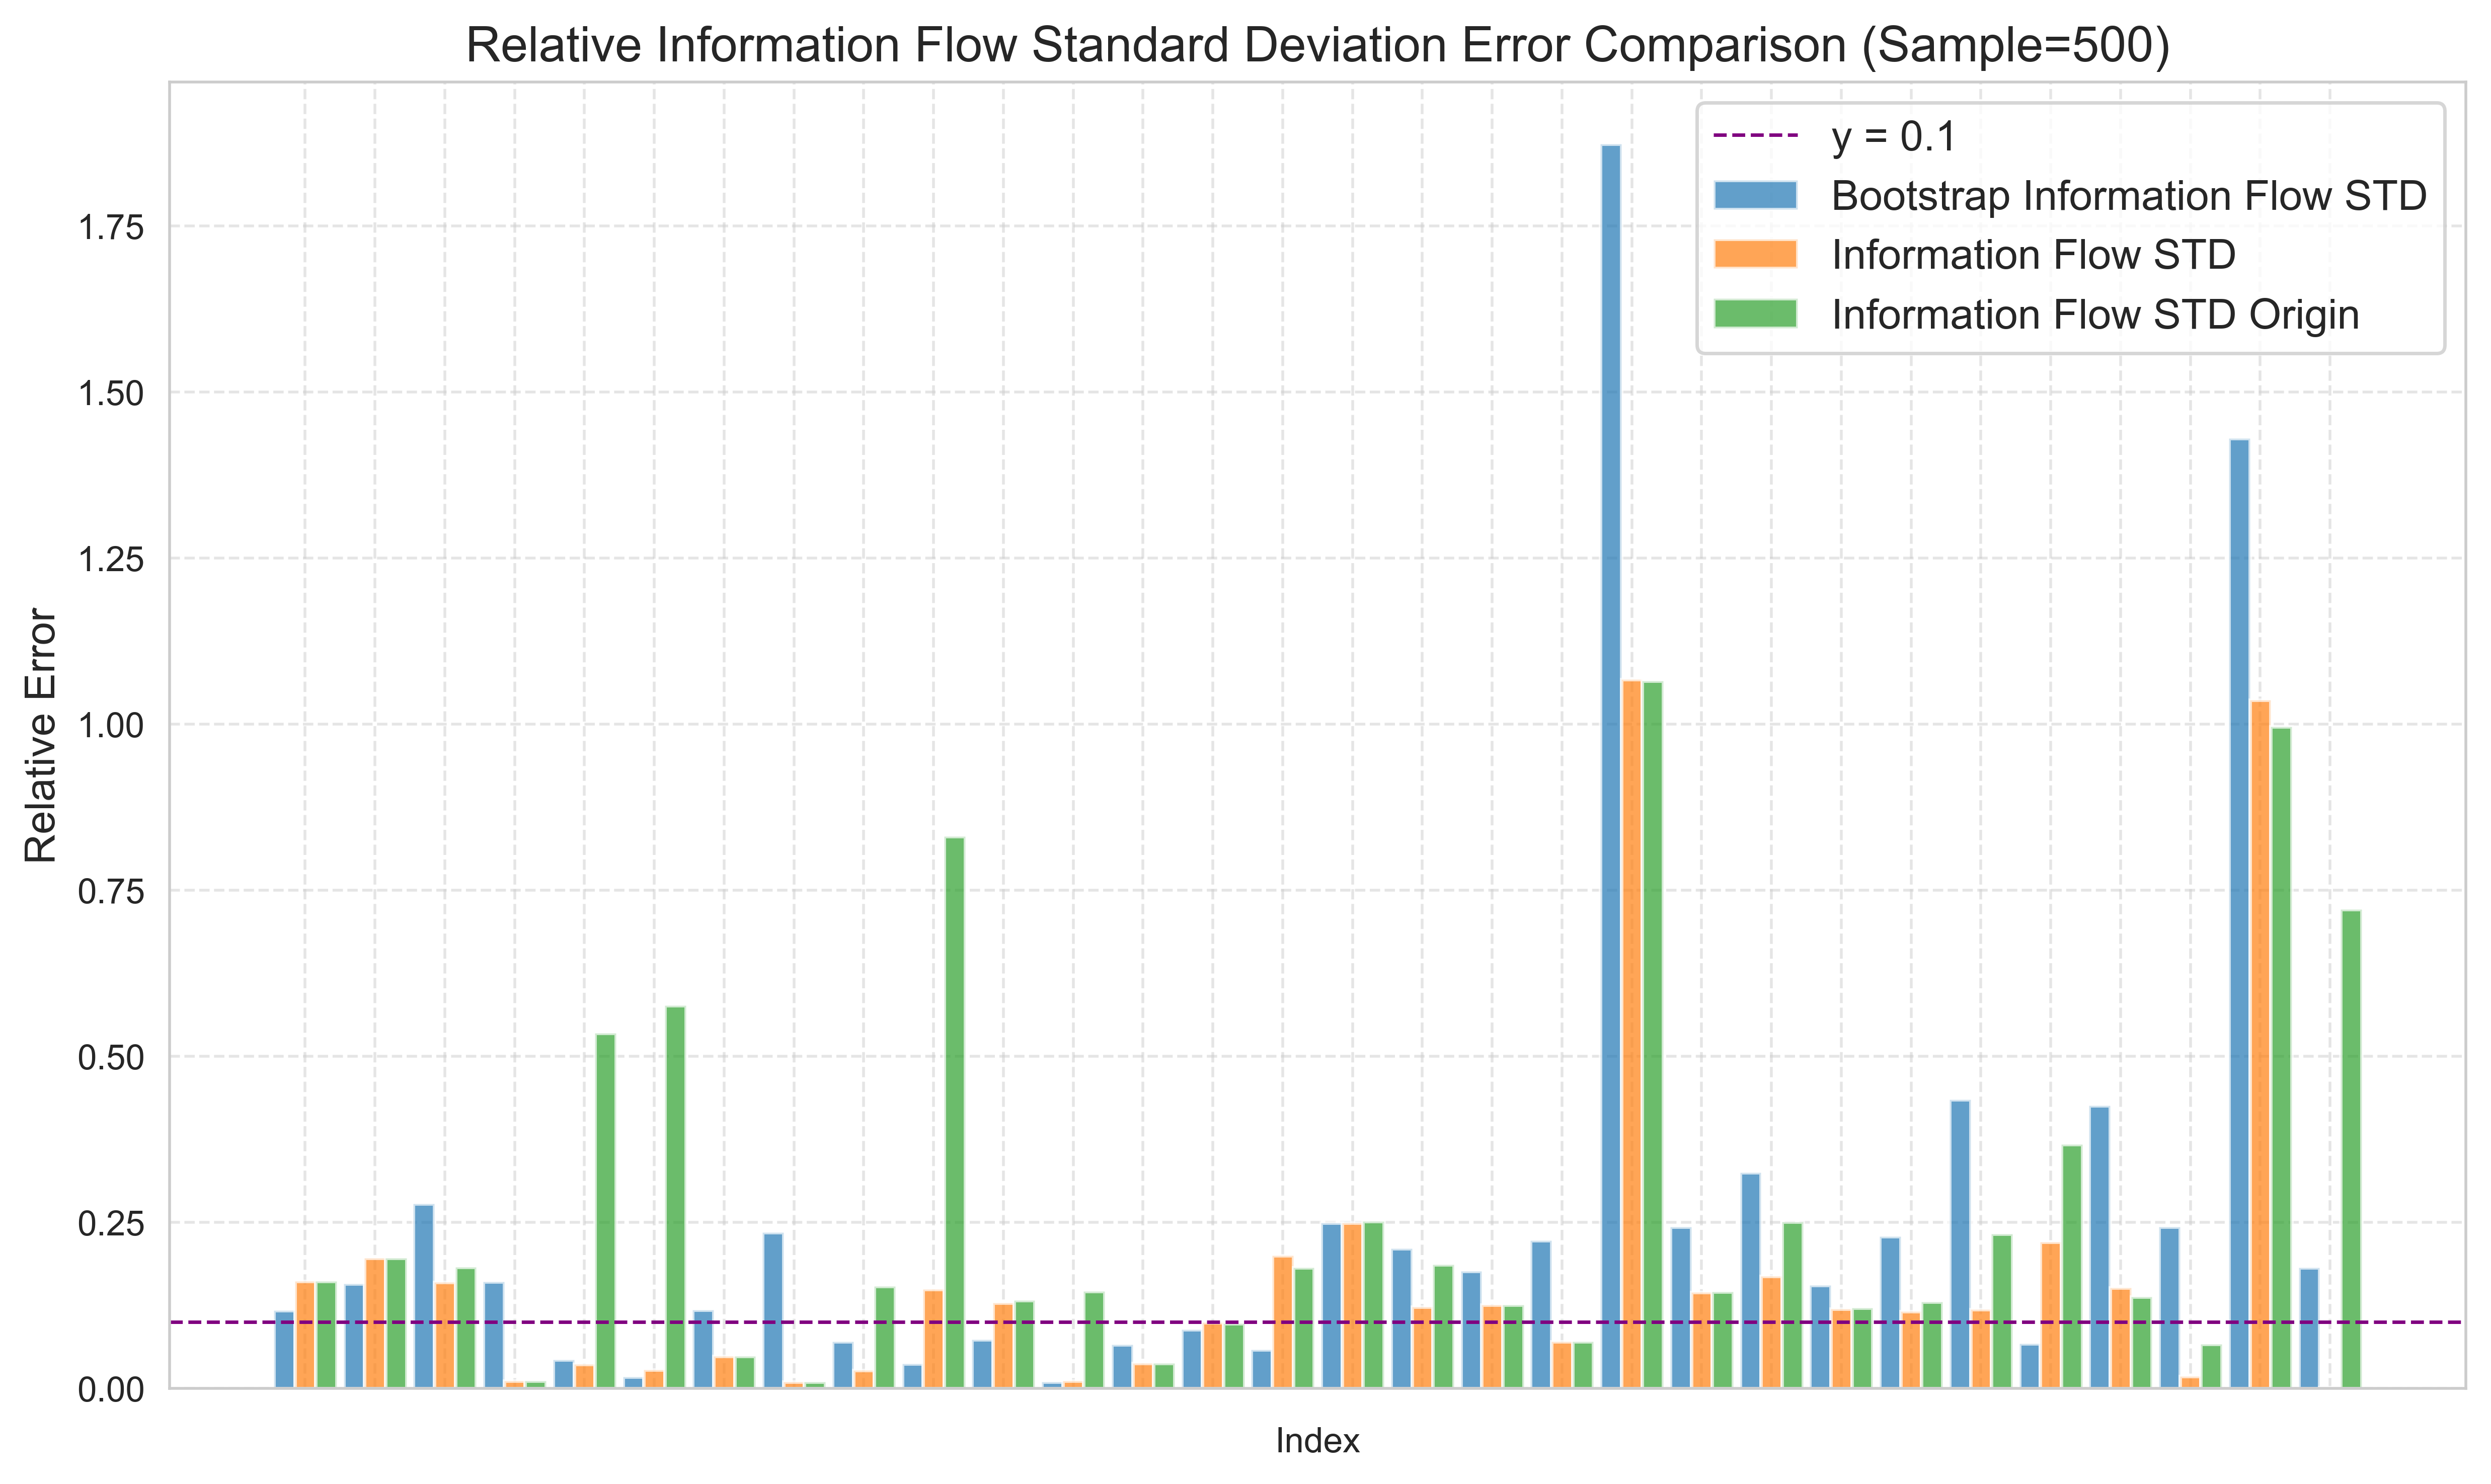

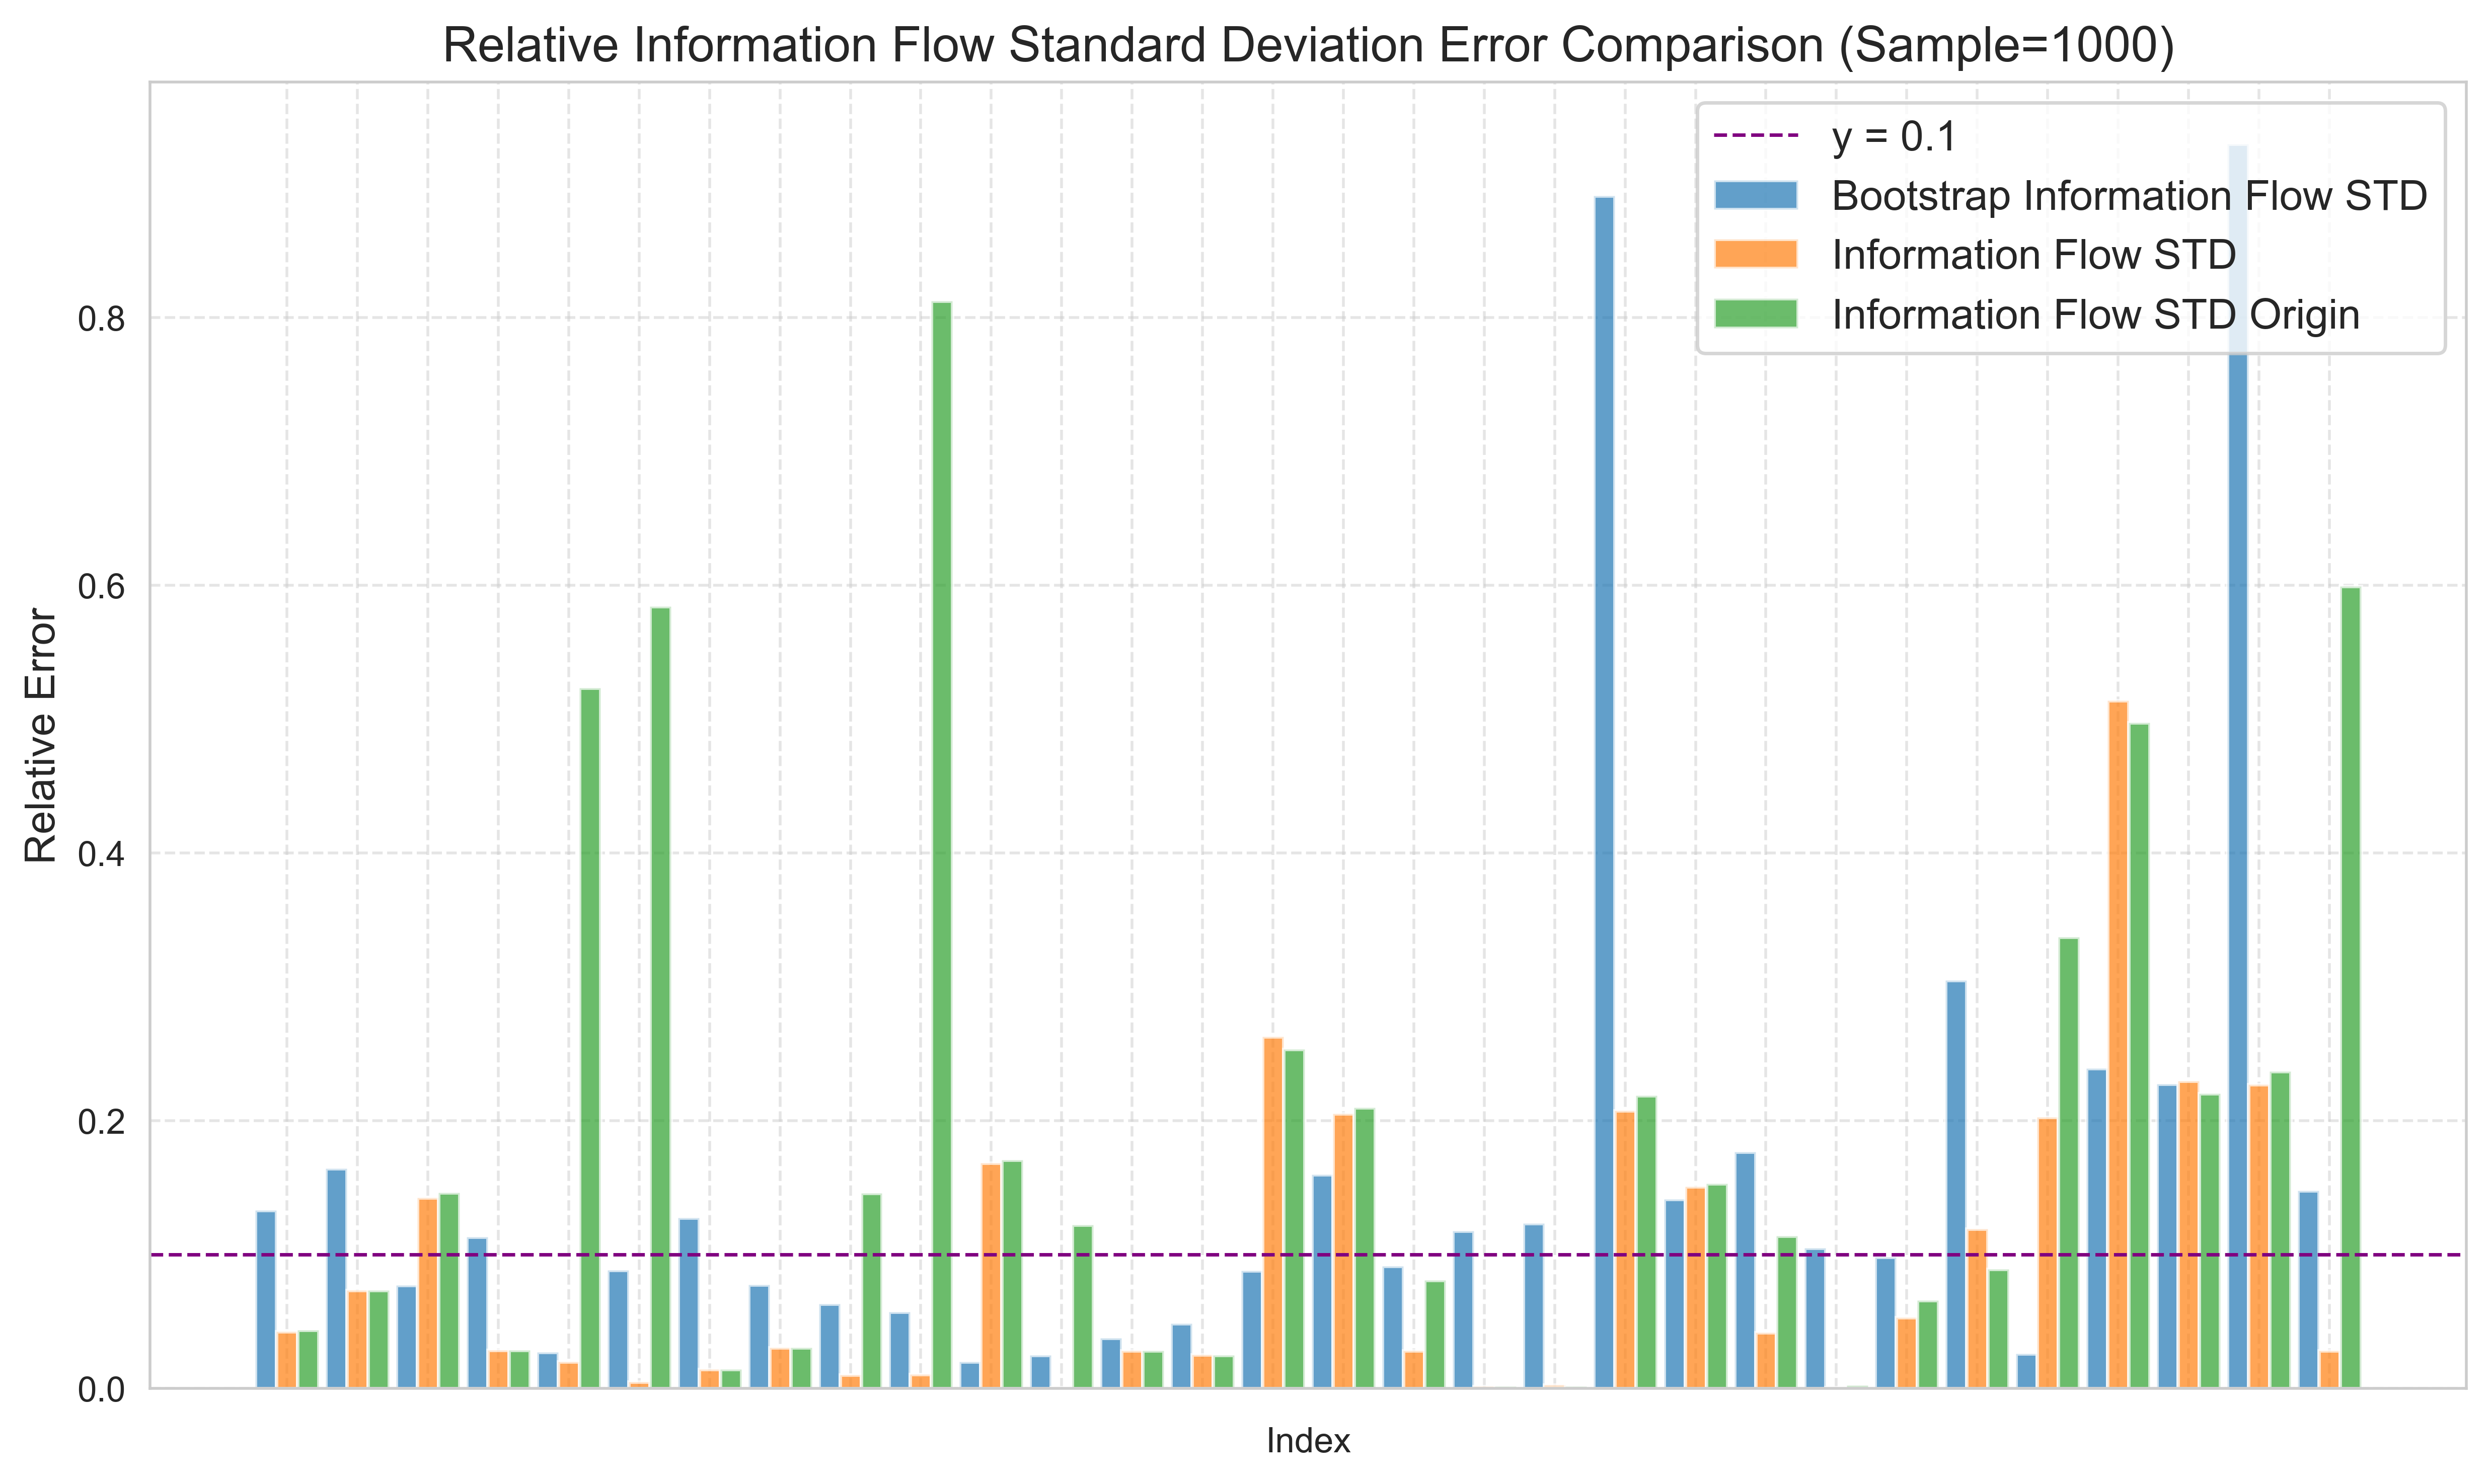

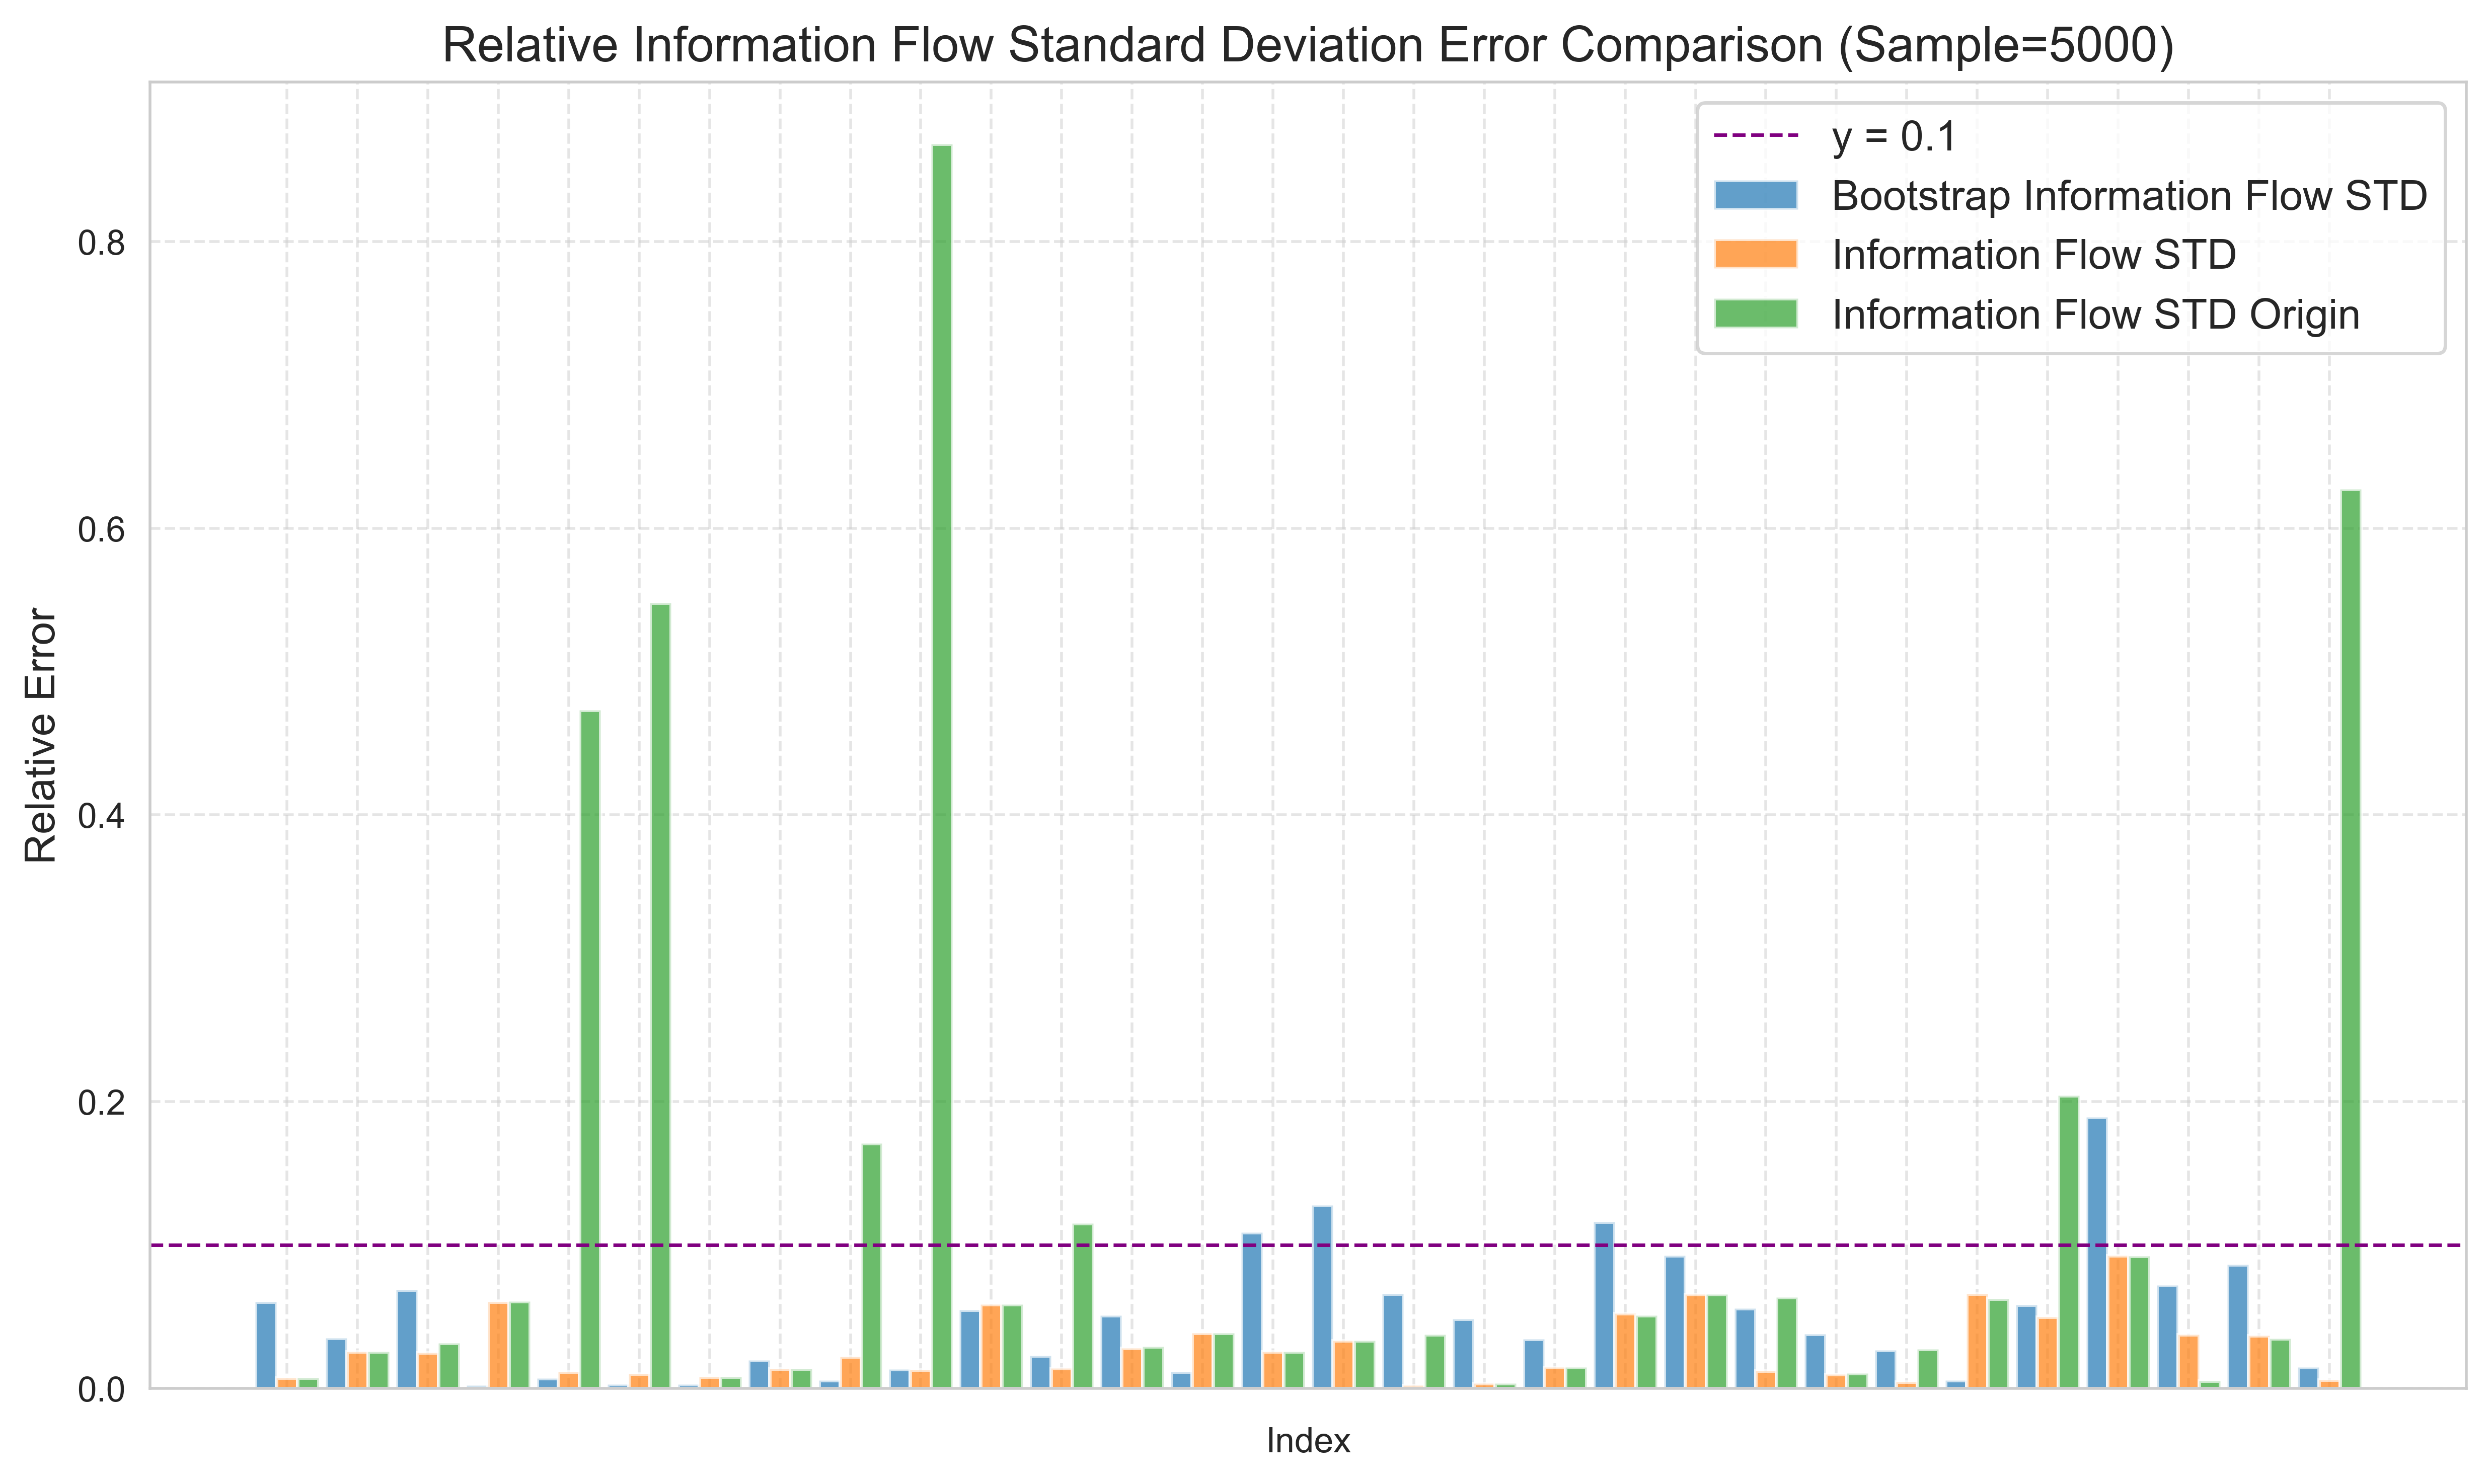

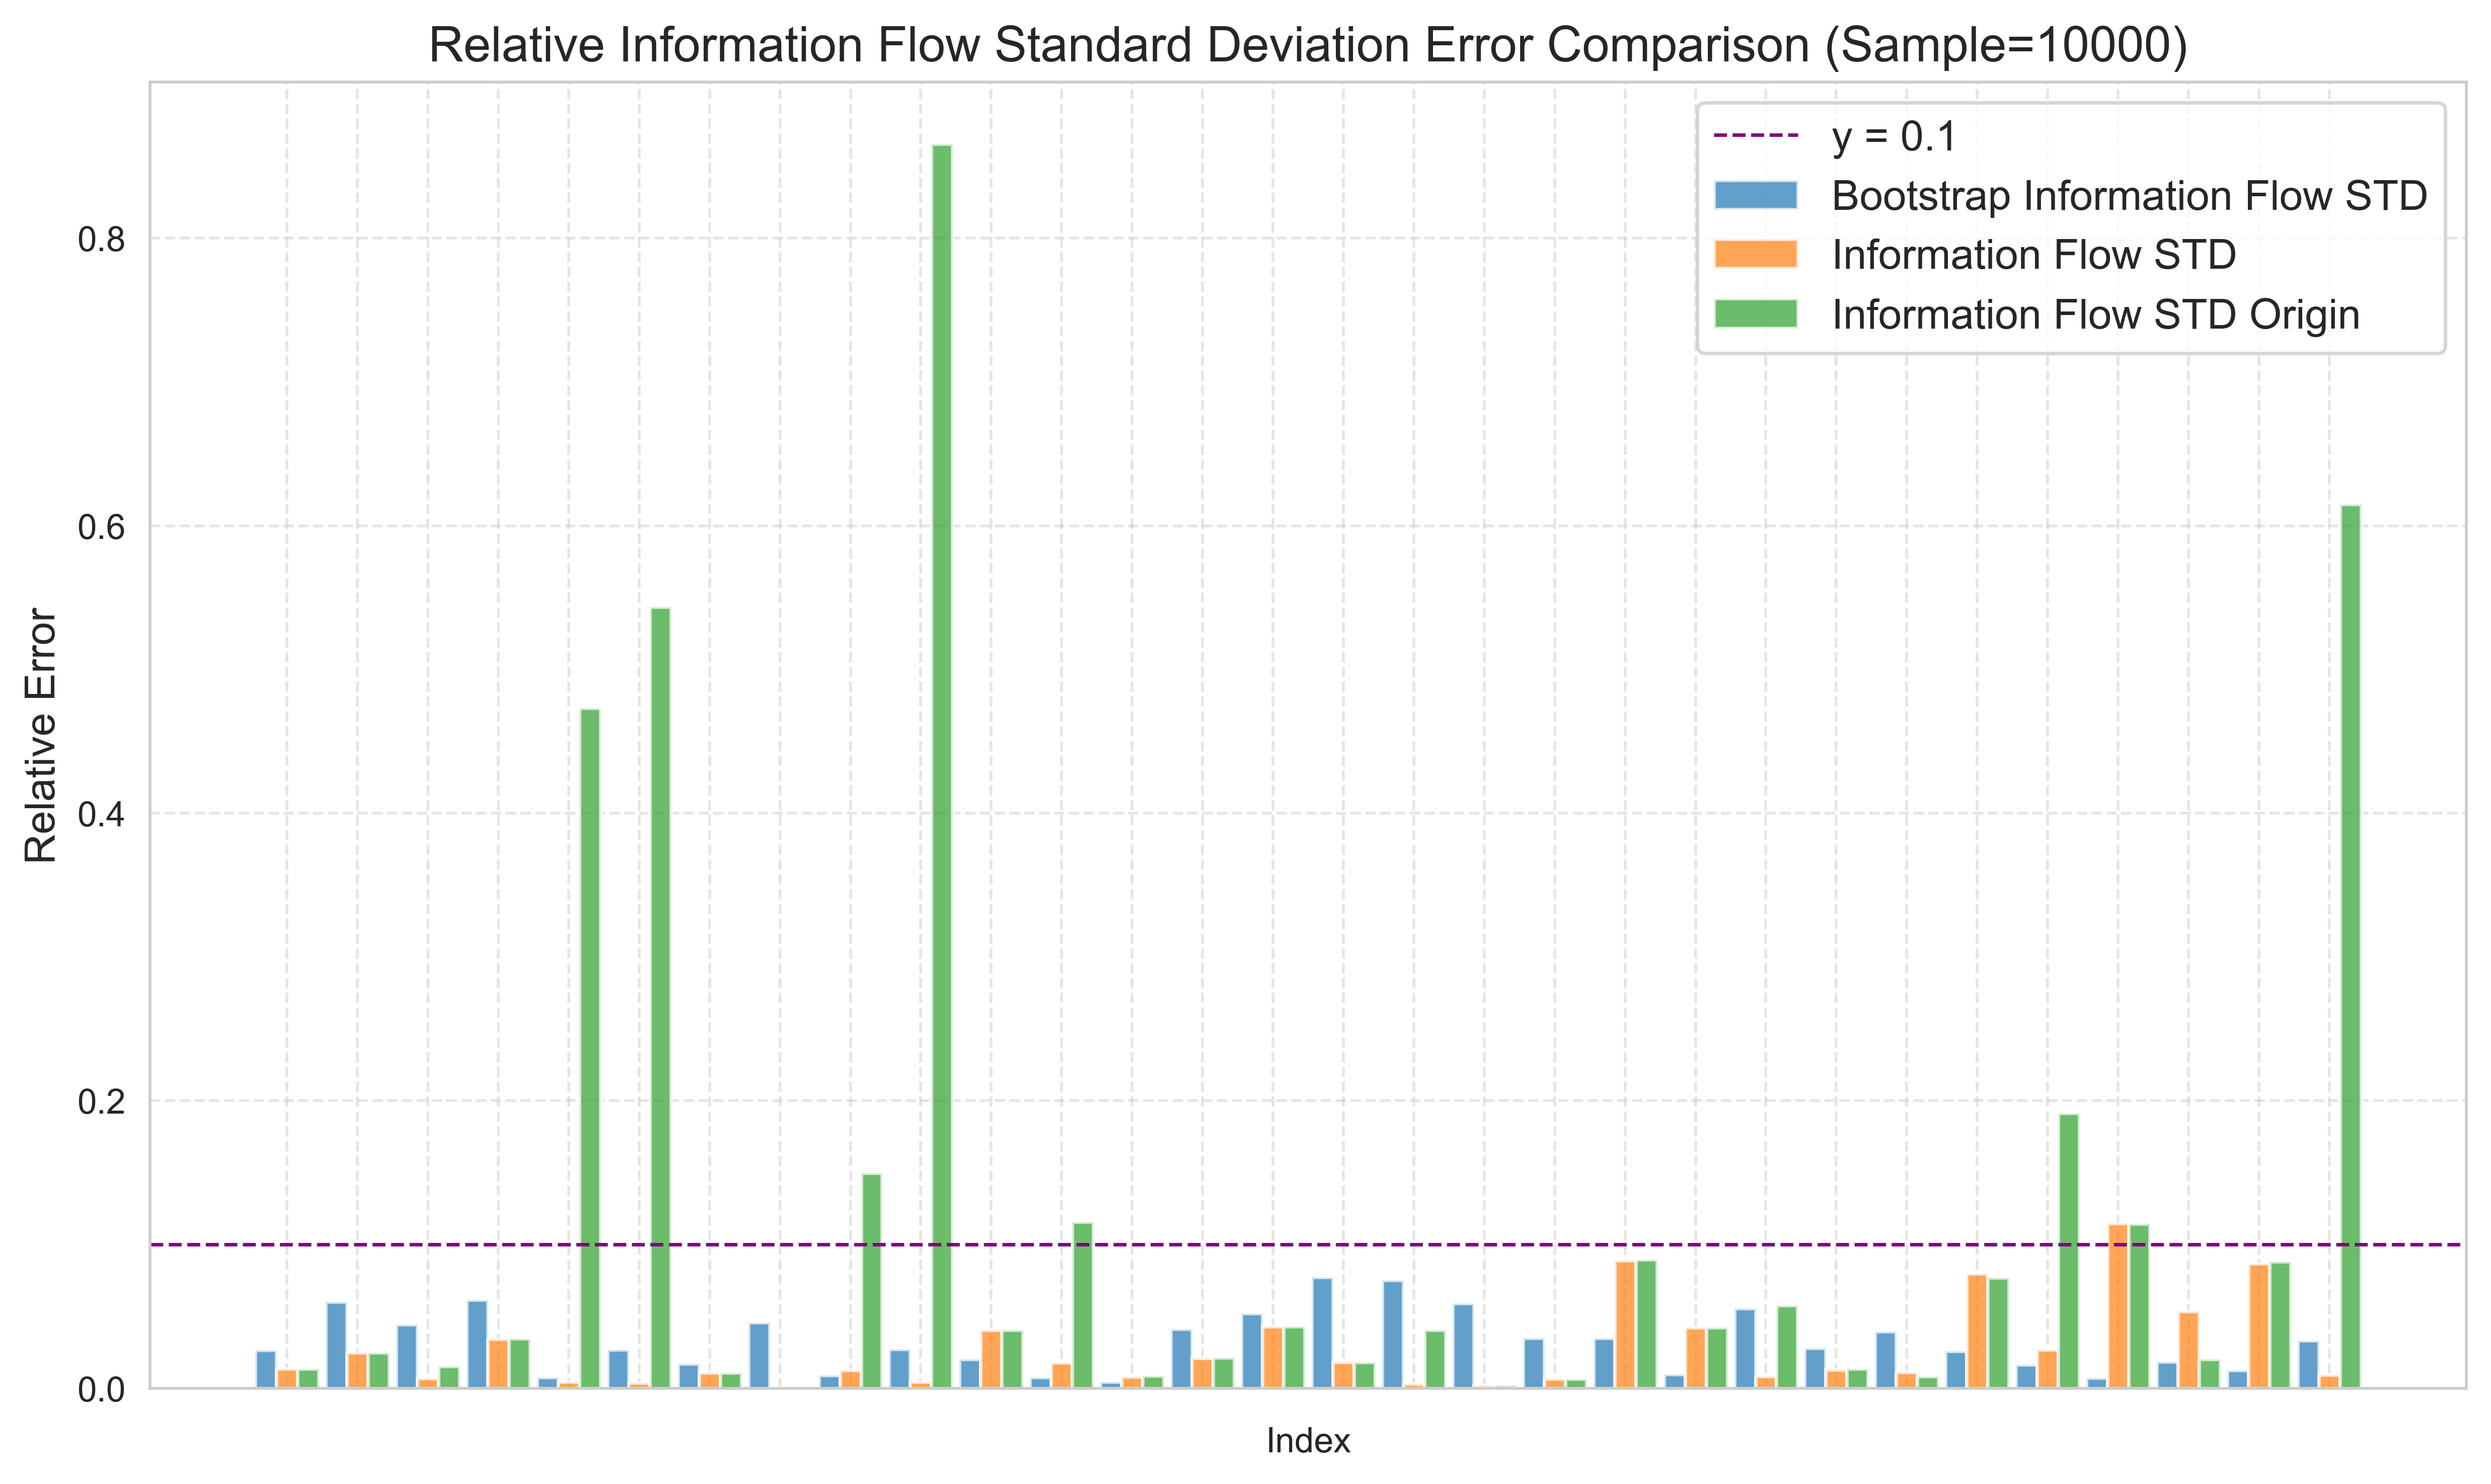

In [27]:
lkif_linear = LinearLKInformationFlow(dt)
for sample_num in [500,1000,5000,10000]:
    segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
    # segments = [(0,3),(3,6)]
    lkif_linear.causality_estimate([X[:,:sample_num].T], lag_list=[1], segments=segments, significance_test=True)
    result_dict = lkif_linear.get_dict()
    bootstrap_result = lkif_linear.bootstrap_estimate([X[:,-sample_num:].T], lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    real_information_flow = lkif_linear.real_information_flow_linear_case(A,B)

    filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
    filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
    filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
    filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

    # 计算相对误差
    y2 = (np.abs(filtered_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y3 = (np.abs(filtered_info_flow_std_origin - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std

    x = np.arange(len(y1))  # x 轴索引
    width = 0.3  # 柱子的宽度

    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    ax.bar(x - width, y1, width, label='Bootstrap Information Flow STD', alpha=0.7)
    ax.bar(x, y2, width, label='Information Flow STD ', alpha=0.7)
    ax.bar(x + width, y3, width, label='Information Flow STD Origin', alpha=0.7)

    # 设置标题和标签
    ax.set_title(f'Relative Information Flow Standard Deviation Error Comparison (Sample={sample_num})', fontsize=14)
    ax.set_xlabel('Index')  # 添加 x 轴标签
    ax.set_ylabel('Relative Error', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([])  # 隐藏 x 轴刻度标签
    ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label='y = 0.1')
    # 添加图例，右上角
    ax.legend(loc='upper right', fontsize=12)

    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 显示图形
    plt.tight_layout()
    plt.savefig(f'figs/2_error_comparison_s_{sample_num}_b_{1000}.eps', format='eps')


---

In [28]:
import numpy as np
from tqdm import tqdm

noise_strength = 1
np.random.seed(29)

# 调整参数
dt = 1 # 时间步长
Nt = 50000  # 时间步数
d = 6  # 维度
# 构建系统矩阵 A
A = np.array([[-0.4,  0.4, -0.6,  0.4,  0.2, -0.2],
       [-0.1, -0.2,  0.4,  0.1, -0.4, -0.2 ],
       [ 0., -0.5, -0.1, -0.2, -0.3 ,  0.1],
       [-0., -0.,  0.2, -0.1,  0.2, -0.3],
       [-0.,  0.,  0., -0.2, -0.1, -0.3],
       [ 0. ,  0.,  0. ,  0.,  0.3, -0.2]])
# A = np.array([[-0.1, 0., 0., -0.1, 0., -0.3],
#               [0.6, -0.2, 0., -0., -0.4, 0.5],
#               [0., 0.6, -0.8, 0.1, -0., -0.],
#               [-0., 0.1, -0., -0.8, 0., 0.],
#               [-0., 0.3, -0.1, 0.6, -0.7, 0.],
#               [-0., -0., -0.1, 0., 0.6, -0.5]])

# 确定噪声矩阵 B
B = np.random.randn(d, d)# 适当缩小噪声规模
f = np.array([0.1,0.1,0.1,0.1,0.1,0.1])
# 初始化状态变量
X = np.zeros((d, Nt))
X[:, 0] = np.random.randn(d)  # 初始状态

# 生成数据
for t in tqdm(range(1, Nt)):
    X[:, t] = X[:, t-1] + (A @ X[:, t-1] +f) + B @ np.random.randn(d)

100%|██████████| 49999/49999 [00:01<00:00, 40786.31it/s]


In [29]:
from lkif import LinearLKInformationFlow
import numpy as np
import matplotlib.pyplot as plt

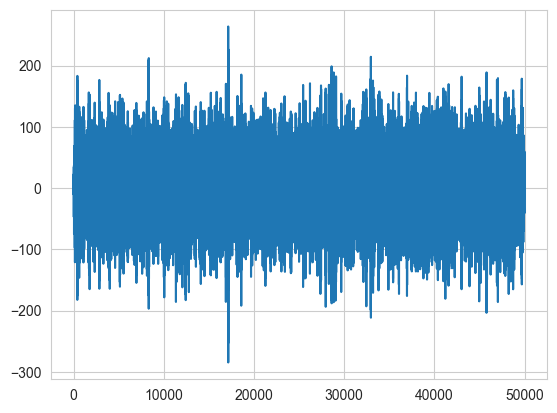

In [30]:
plt.plot(X[0,:])

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

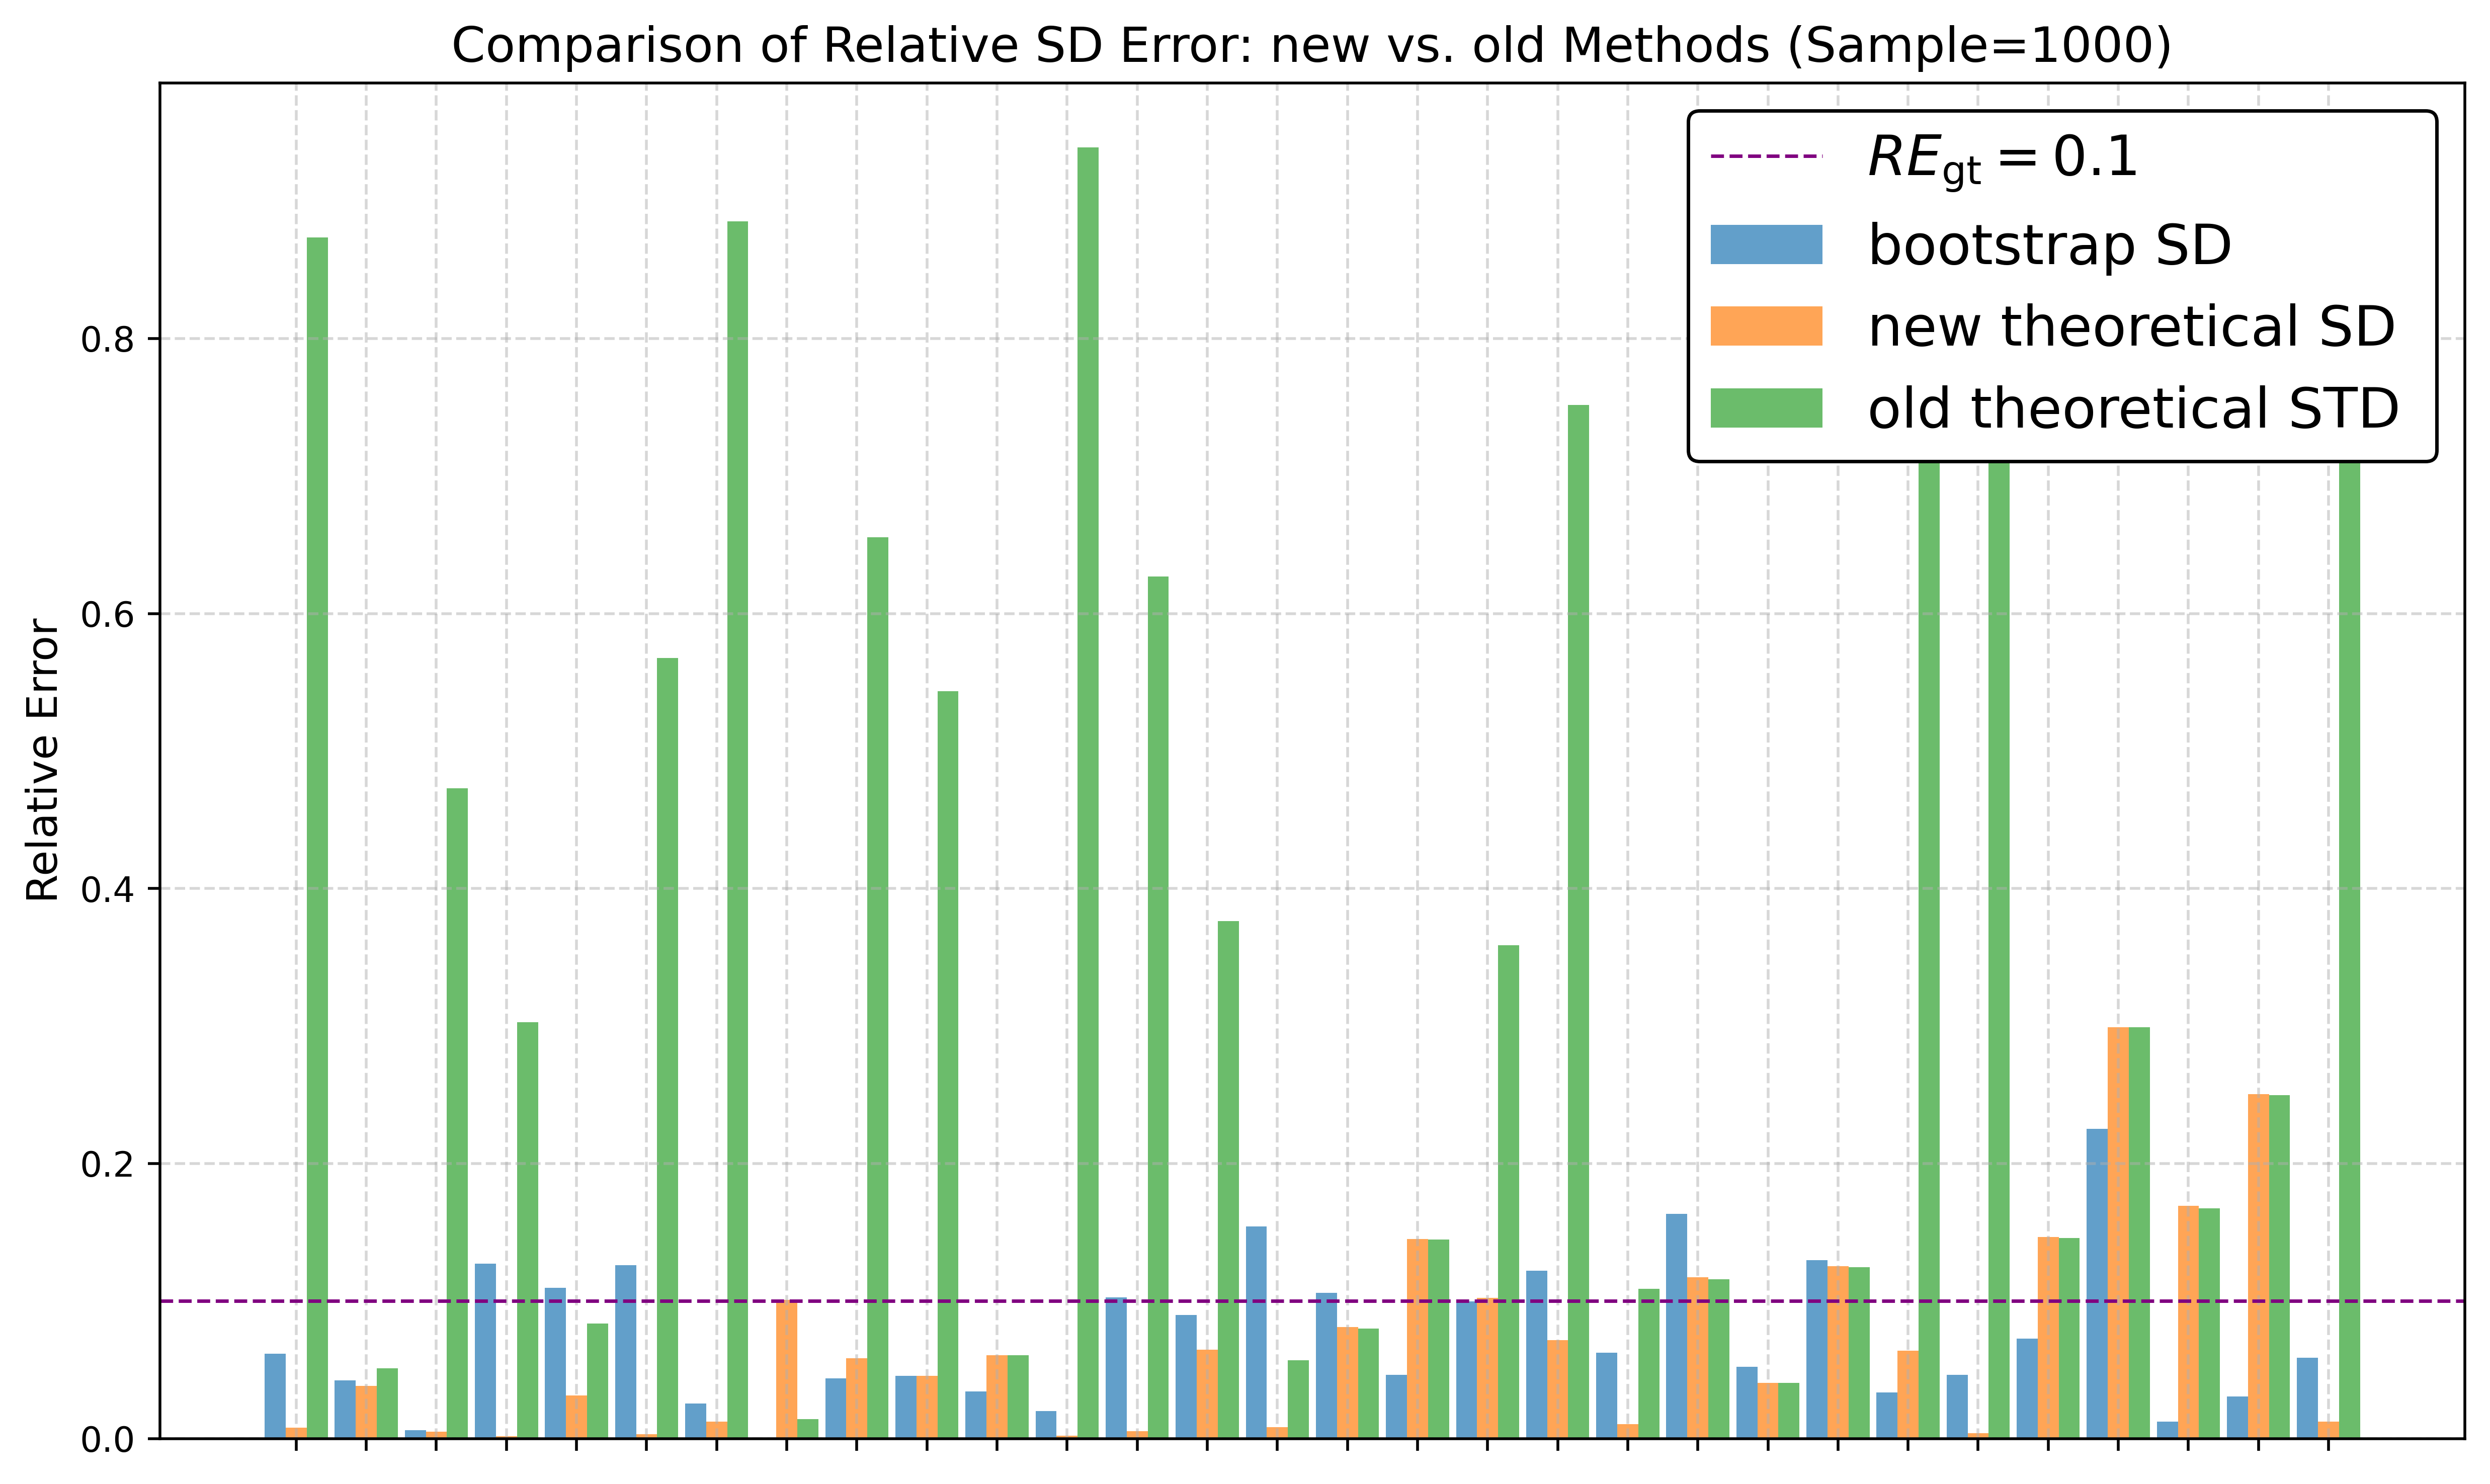

In [8]:
## 去掉对角元素
def remove_diagonal(matrix):
    mask = ~np.eye(matrix.shape[0], dtype=bool)
    return matrix[mask].flatten()
lkif_linear = LinearLKInformationFlow(dt)
segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
sample_num = 1000
lkif_linear.causality_estimate([X[:,:sample_num].T], lag_list=[1], segments=segments, significance_test=True)
result_dict = lkif_linear.get_dict()
bootstrap_result = lkif_linear.bootstrap_estimate([X[:,-sample_num:].T], lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
real_information_flow = lkif_linear.real_information_flow_linear_case(A,B)

filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

# 计算相对误差
y2 = (np.abs(filtered_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std
y3 = (np.abs(filtered_info_flow_std_origin - filtered_real_info_flow_std)) / filtered_real_info_flow_std
y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std


x = np.arange(len(y1))  # x 轴索引
width = 0.3  # 柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
ax.bar(x - width, y1, width, label='bootstrap SD', alpha=0.7)
ax.bar(x, y2, width, label='new theoretical SD ', alpha=0.7)
ax.bar(x + width, y3, width, label='old theoretical STD', alpha=0.7)

# 添加 y=0.1 的虚线
ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label=r"$RE_{\mathrm{gt}} = 0.1$")


# 设置标题和标签
ax.set_title(f'Comparison of Relative SD Error: new vs. old Methods (Sample={sample_num})', fontsize=14)
# ax.set_xlabel('Index')  # 添加 x 轴标签
ax.set_ylabel('Relative Error', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([])  # 隐藏 x 轴刻度标签

ax.legend(loc='upper right', fontsize=16, frameon=True, framealpha=1, edgecolor="black", fancybox=True)

# 设置网格
ax.grid(True, linestyle='--', alpha=0.5)

# 显示图形
plt.tight_layout()

In [5]:
labels = [
    (1,2), (1,3), (1,4), (1,5), (1,6),
    (2,1), (2,3), (2,4), (2,5), (2,6),
    (3,1), (3,2), (3,4), (3,5), (3,6),
    (4,1), (4,2), (4,3), (4,5), (4,6),
    (5,1), (5,2), (5,3), (5,4), (5,6),
    (6,1), (6,2), (6,3), (6,4), (6,5)
]
import matplotlib.ticker as mticker

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


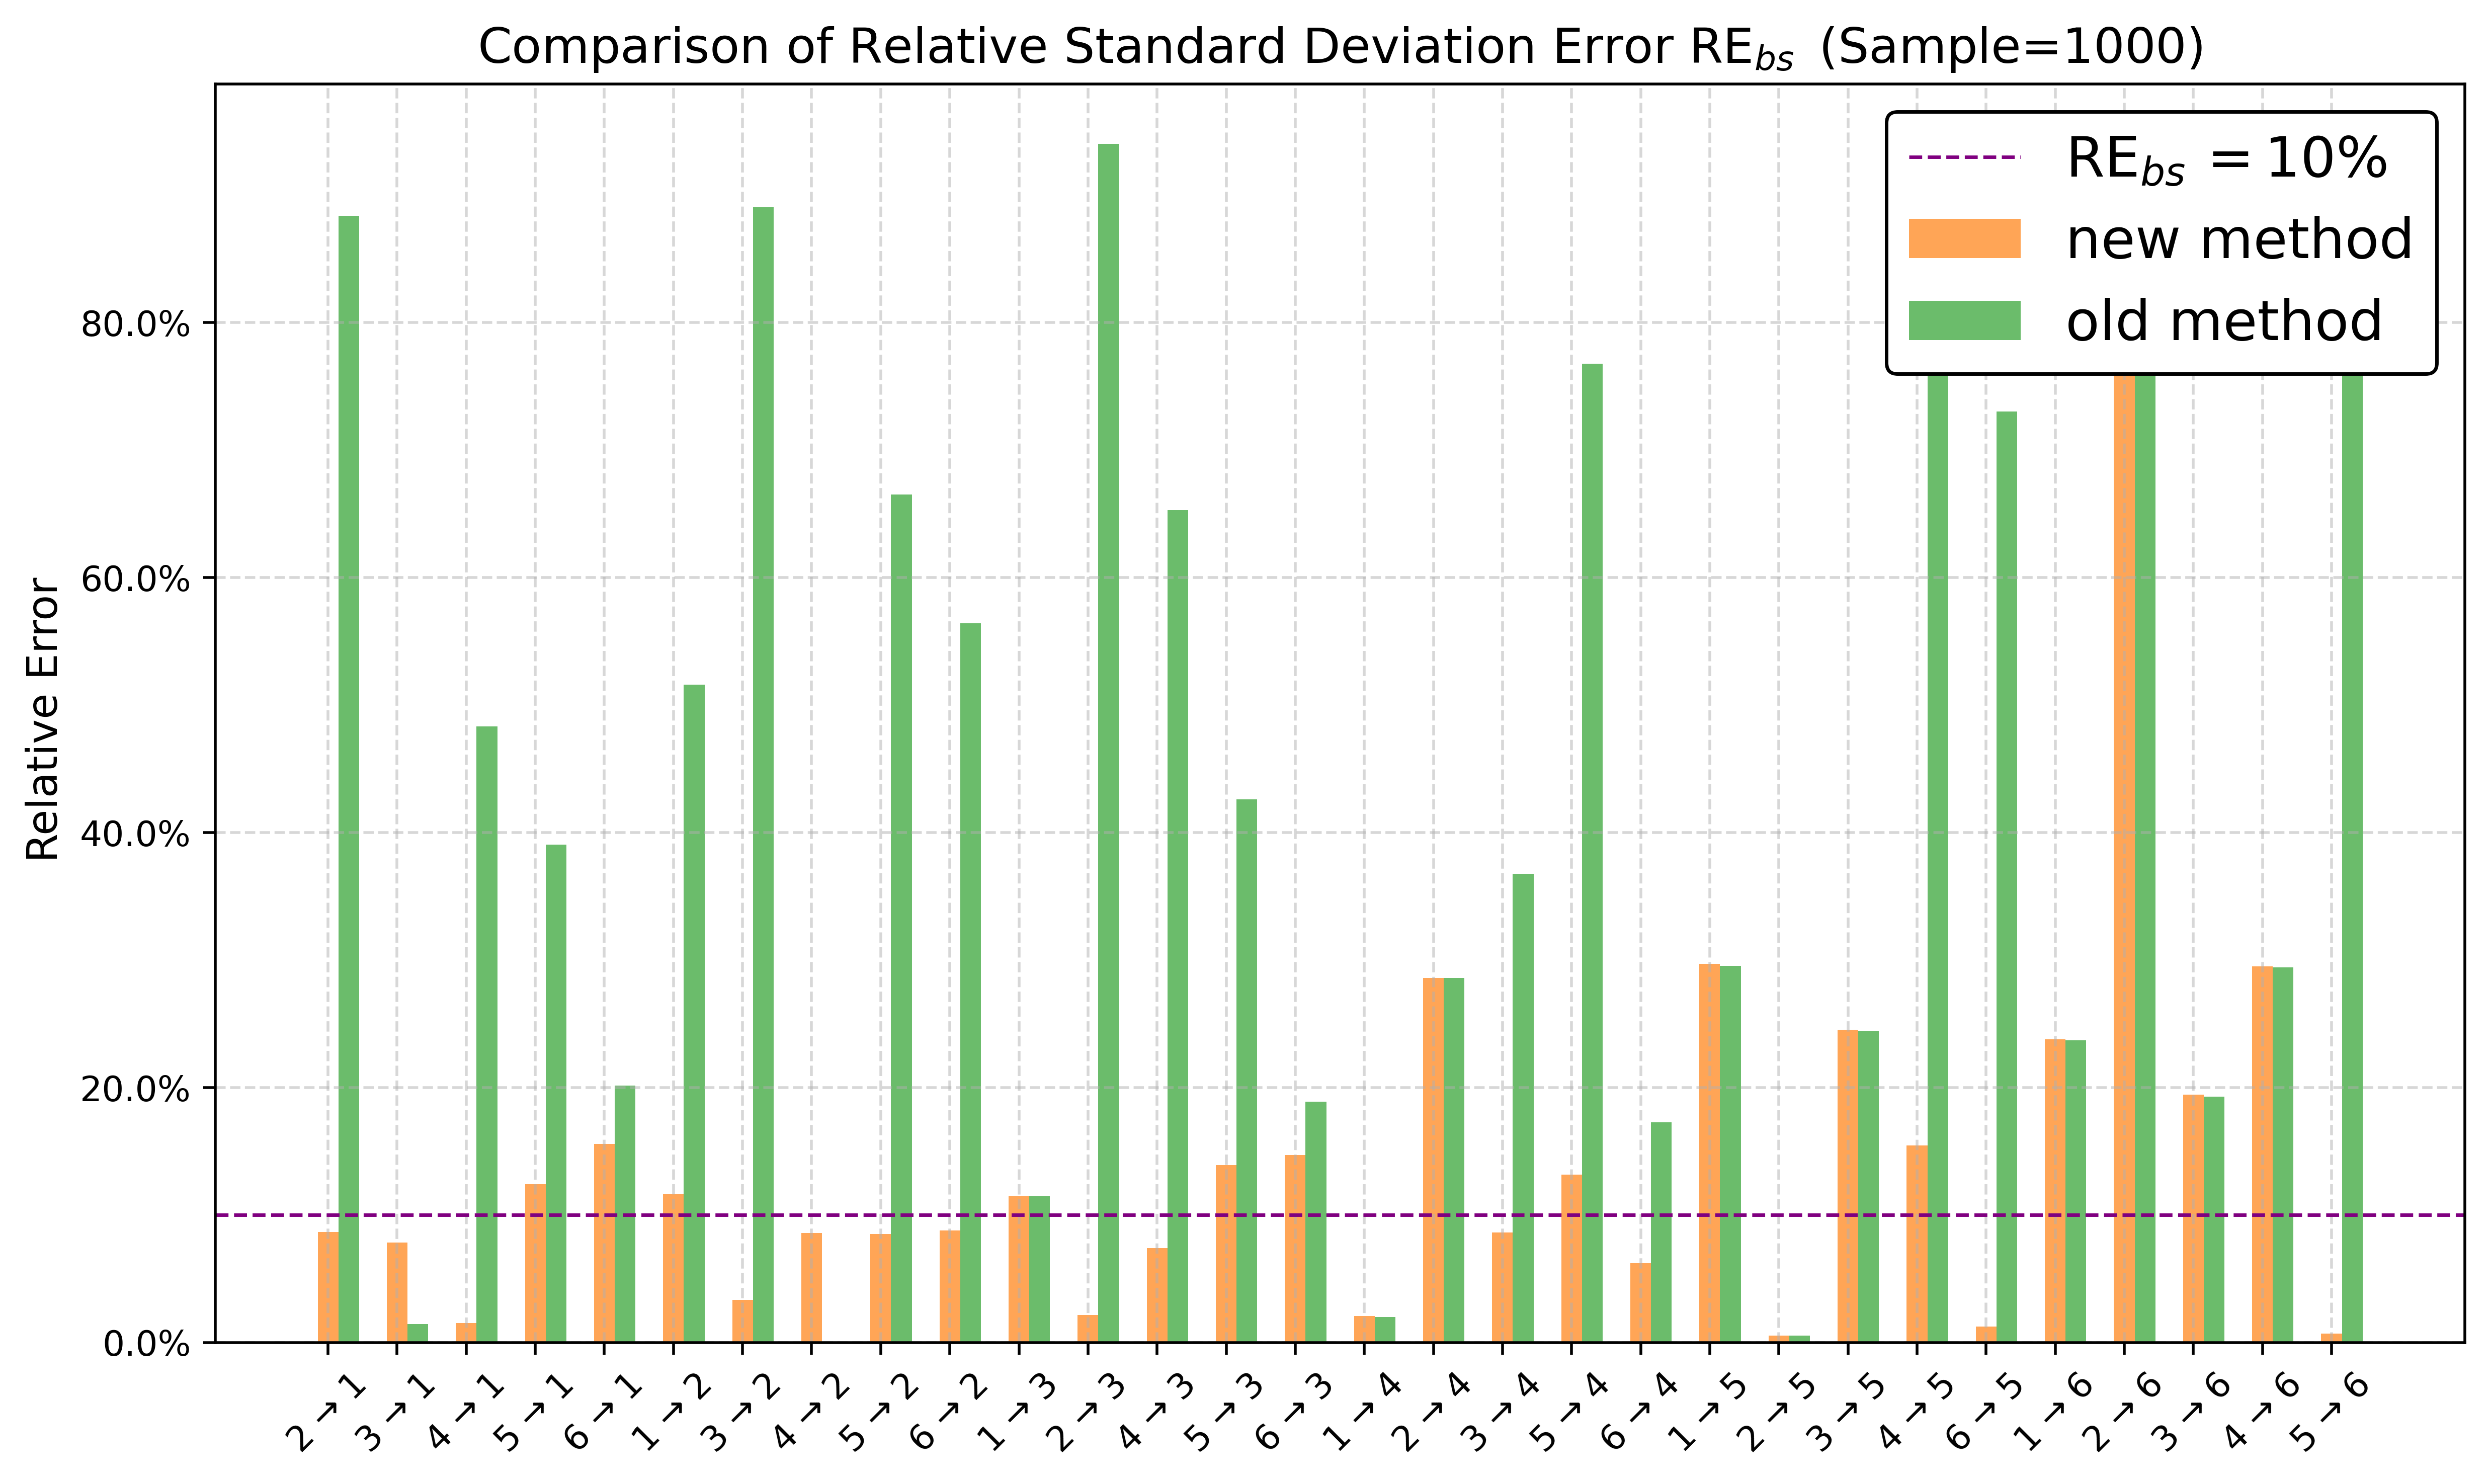

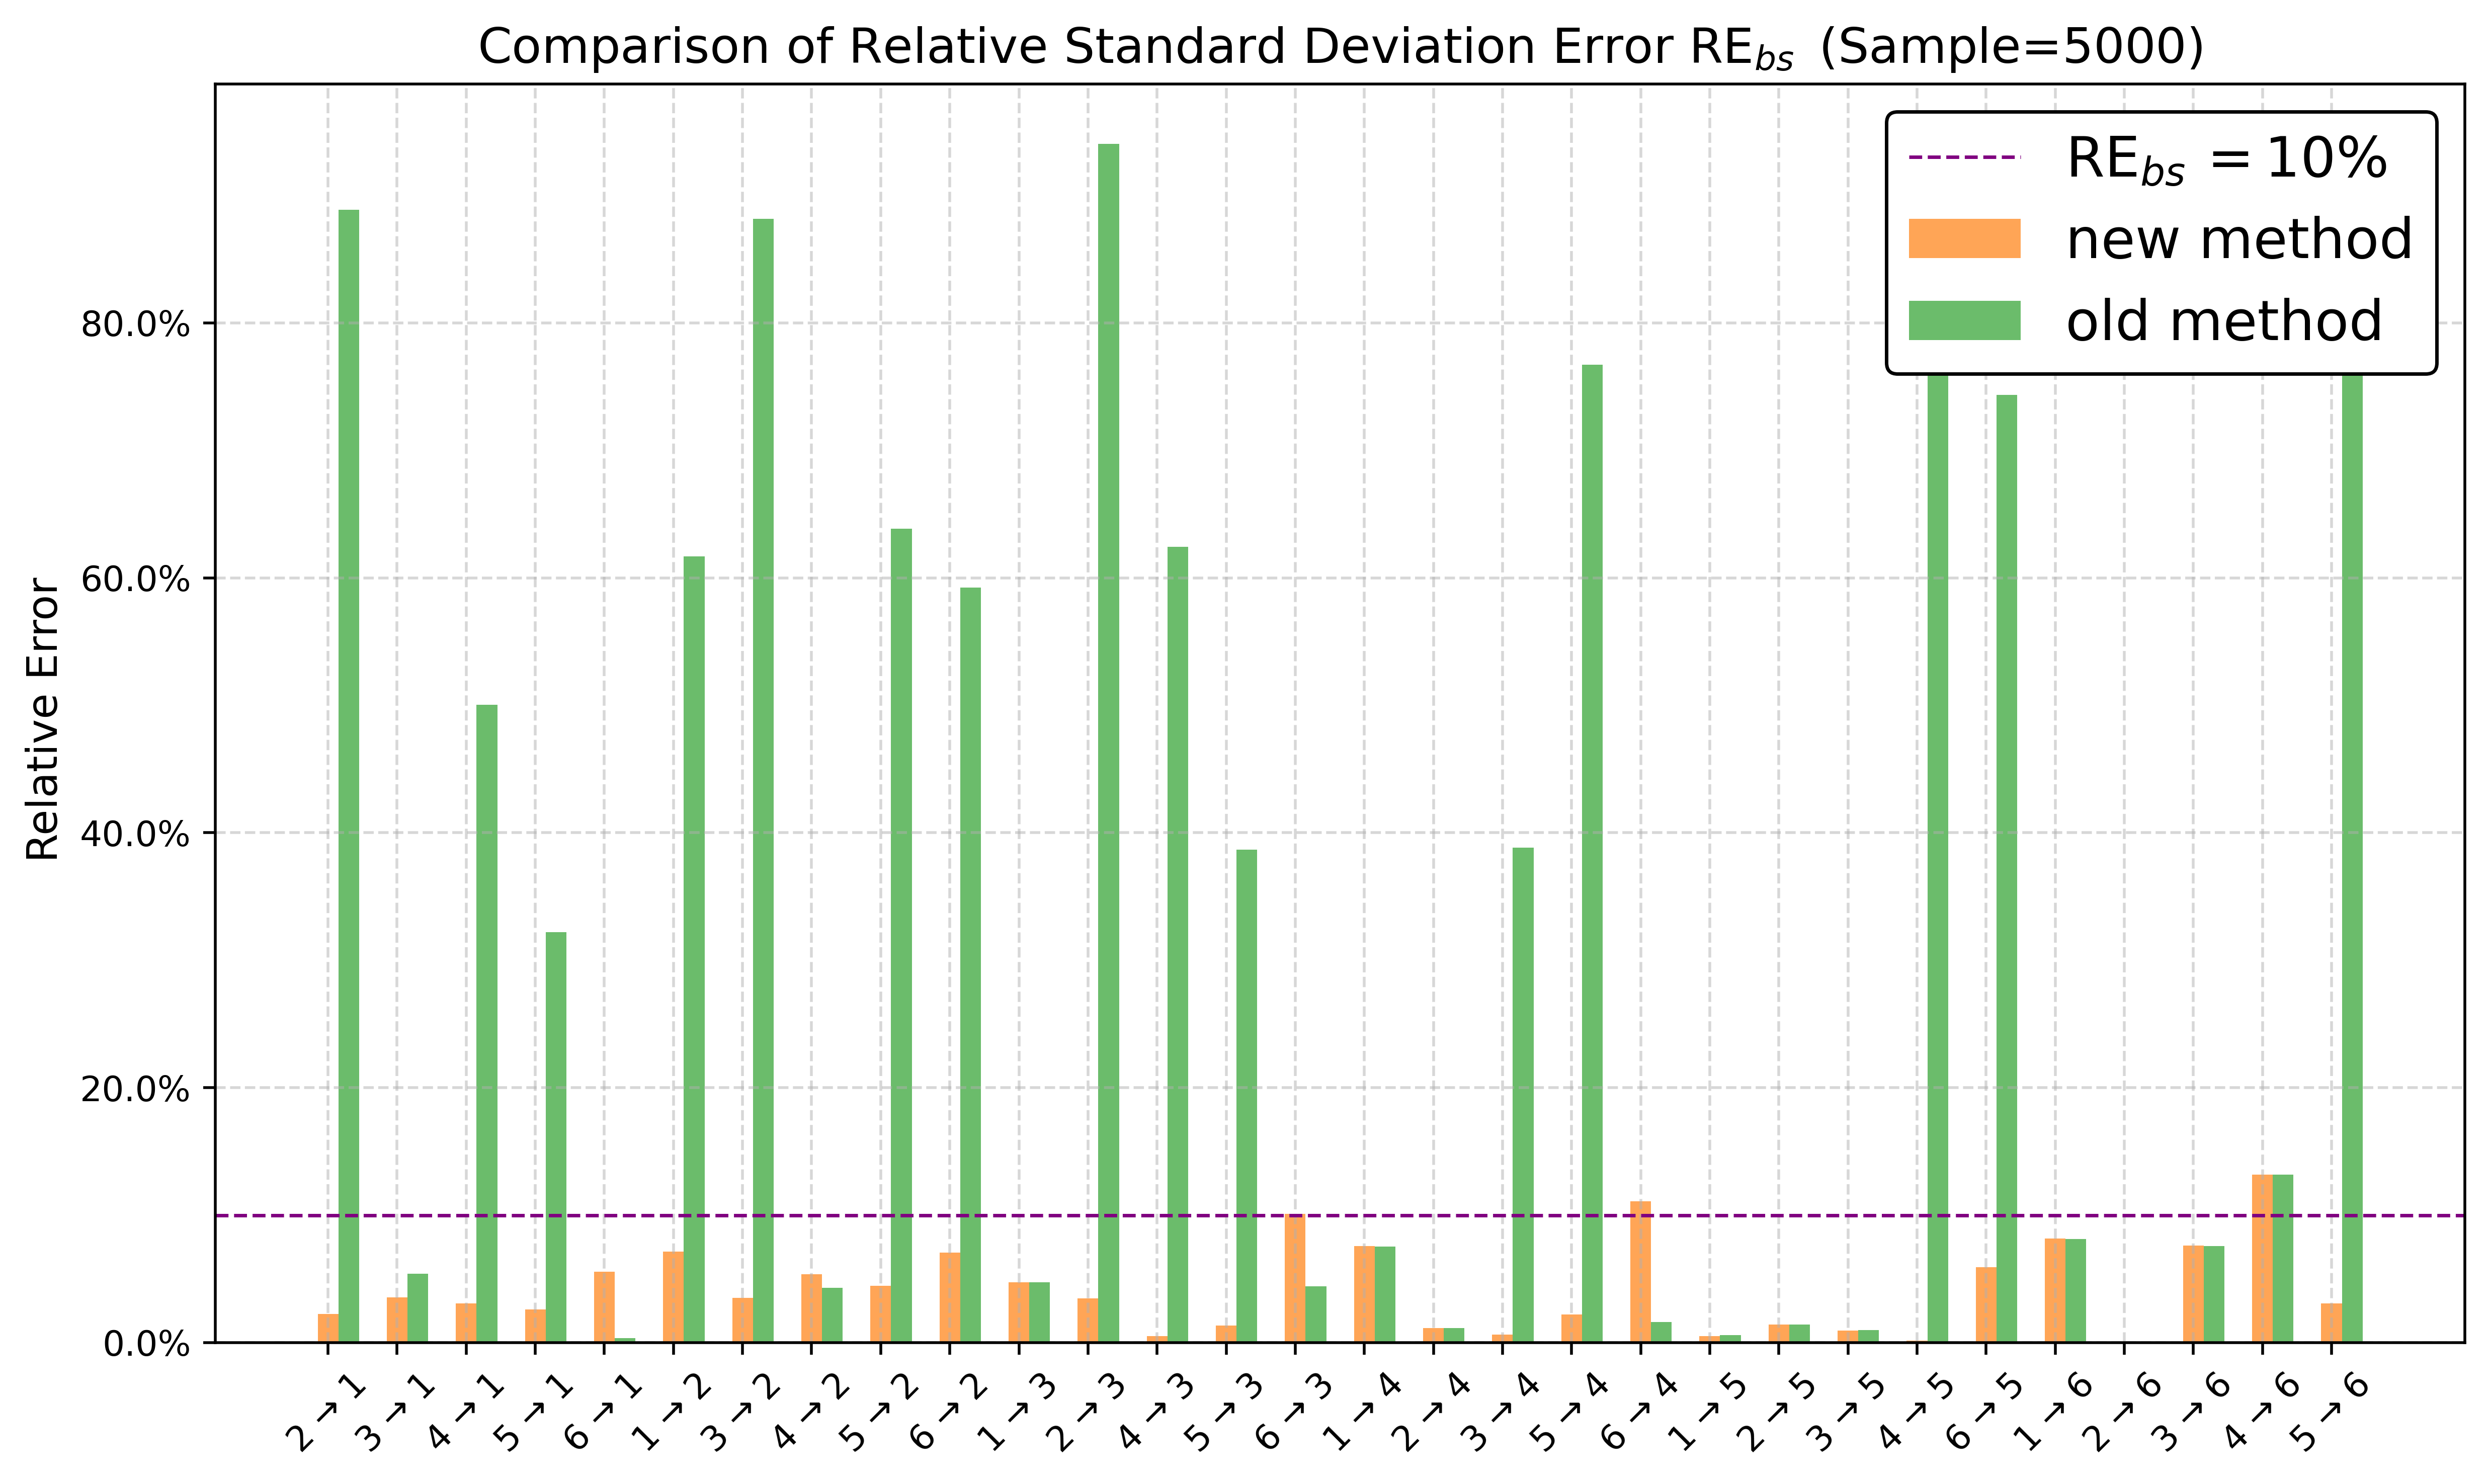

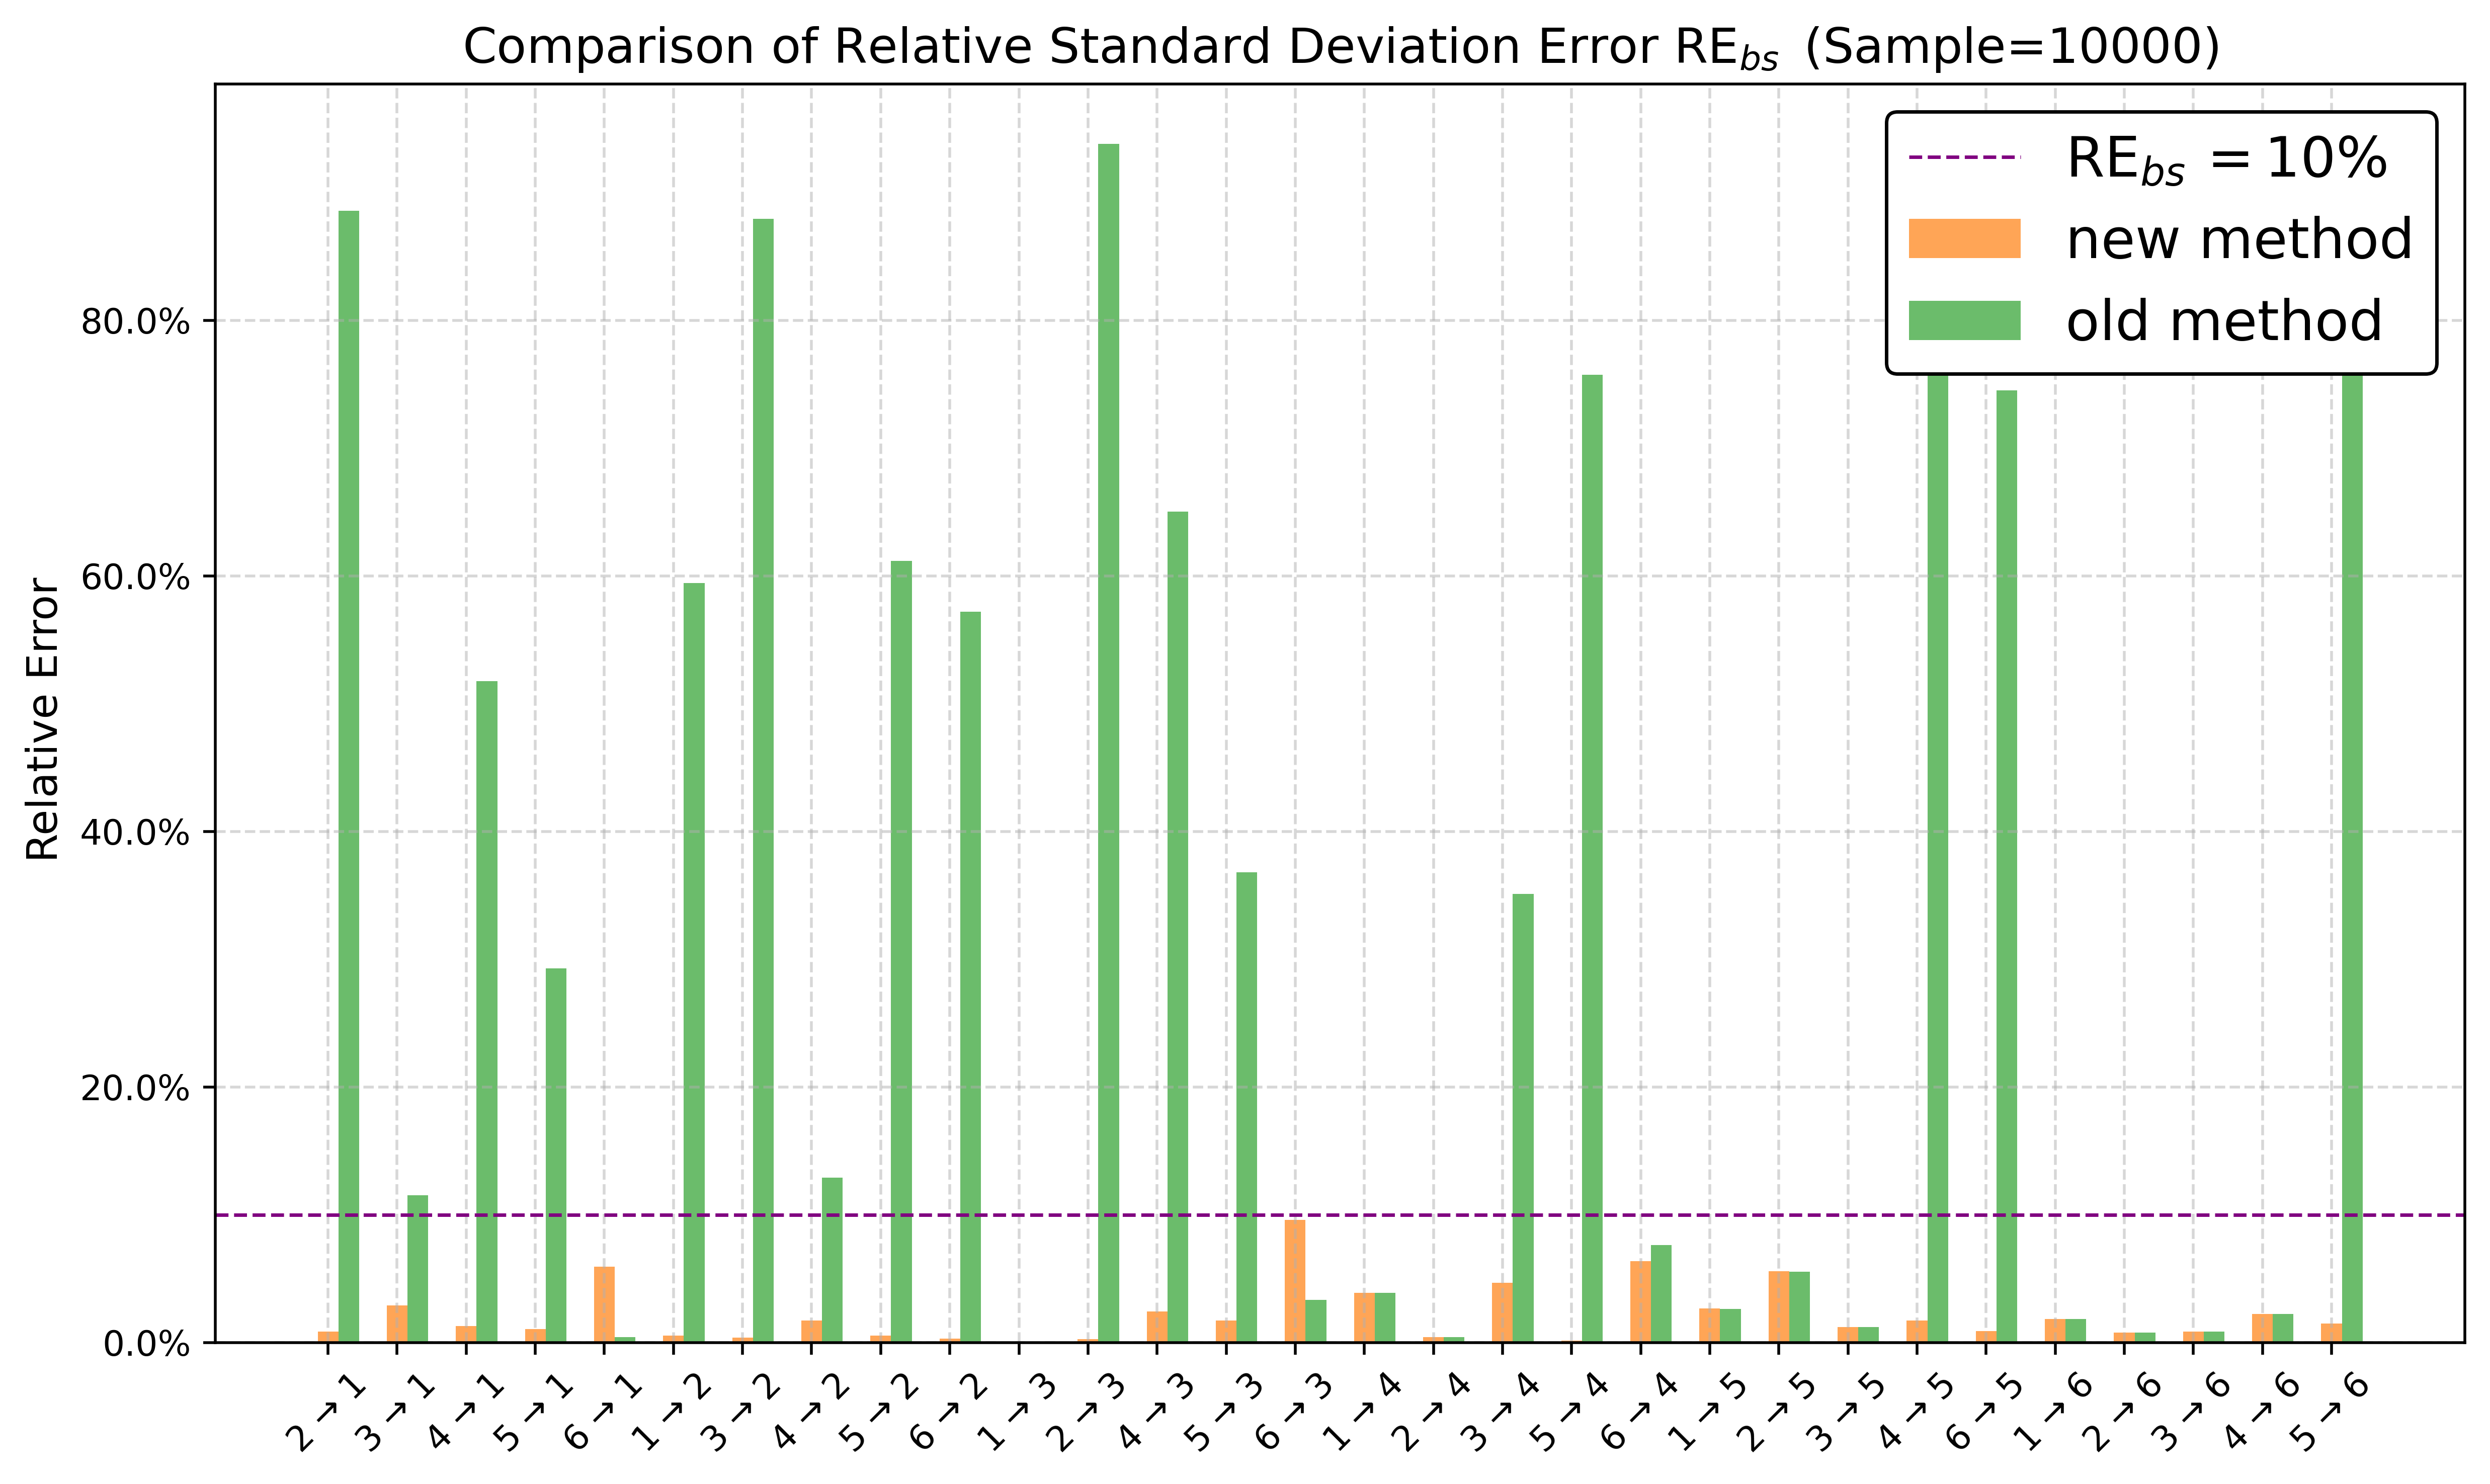

In [9]:
lkif_linear = LinearLKInformationFlow(dt)
for sample_num in [1000,5000,10000]:
    segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
    # segments = [(0,3),(3,6)]
    lkif_linear.causality_estimate([X[:,:sample_num].T], lag_list=[1], segments=segments, significance_test=True)
    result_dict = lkif_linear.get_dict()
    bootstrap_result = lkif_linear.bootstrap_estimate([X[:,-sample_num:].T], lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    real_information_flow = lkif_linear.real_information_flow_linear_case(A,B)
    
    filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
    filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
    filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
    filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

    # 计算相对误差
    y2 = (np.abs(filtered_info_flow_std - filtered_bootstrap_info_flow_std)) / filtered_bootstrap_info_flow_std
    y3 = (np.abs(filtered_info_flow_std_origin - filtered_bootstrap_info_flow_std)) / filtered_bootstrap_info_flow_std
    # y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std

  
    x = np.arange(len(y2))  # x 轴索引
    width = 0.3  # 柱子的宽度

    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    # ax.bar(x - width, y1, width, label='Bootstrap Information Flow STD', alpha=0.7)
    ax.bar(x, y2, width, label='new method', alpha=0.7,color='tab:orange')
    ax.bar(x + width, y3, width, label='old method', alpha=0.7,color='tab:green')

    # 添加 y=0.1 的虚线
    ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label=r"$\operatorname{RE}_{bs} = 10\%$")

    # 设置标题和标签
    ax.set_title(r'Comparison of Relative Standard Deviation Error $\operatorname{RE}_{bs}$'+f' (Sample={sample_num})', fontsize=14)
    # ax.set_xlabel('Index')  # 添加 x 轴标签
    ax.set_ylabel('Relative Error ', fontsize=12)

    # 将 y 轴转换为百分比格式
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
    ax.set_xticks(x)
    ax.set_xticklabels([f"{j} → {i}" for i, j in labels], rotation=45)

    # ax.set_xticklabels([])  # 隐藏 x 轴刻度标签

    # 添加图例，右上角
    ax.legend(loc='upper right', fontsize=16, frameon=True, framealpha=1, edgecolor="black", fancybox=True)

    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 显示图形
    plt.tight_layout()
    plt.savefig(f'figs/3_error_comparison_s_{sample_num}_b_{1000}.eps', format='eps')



Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


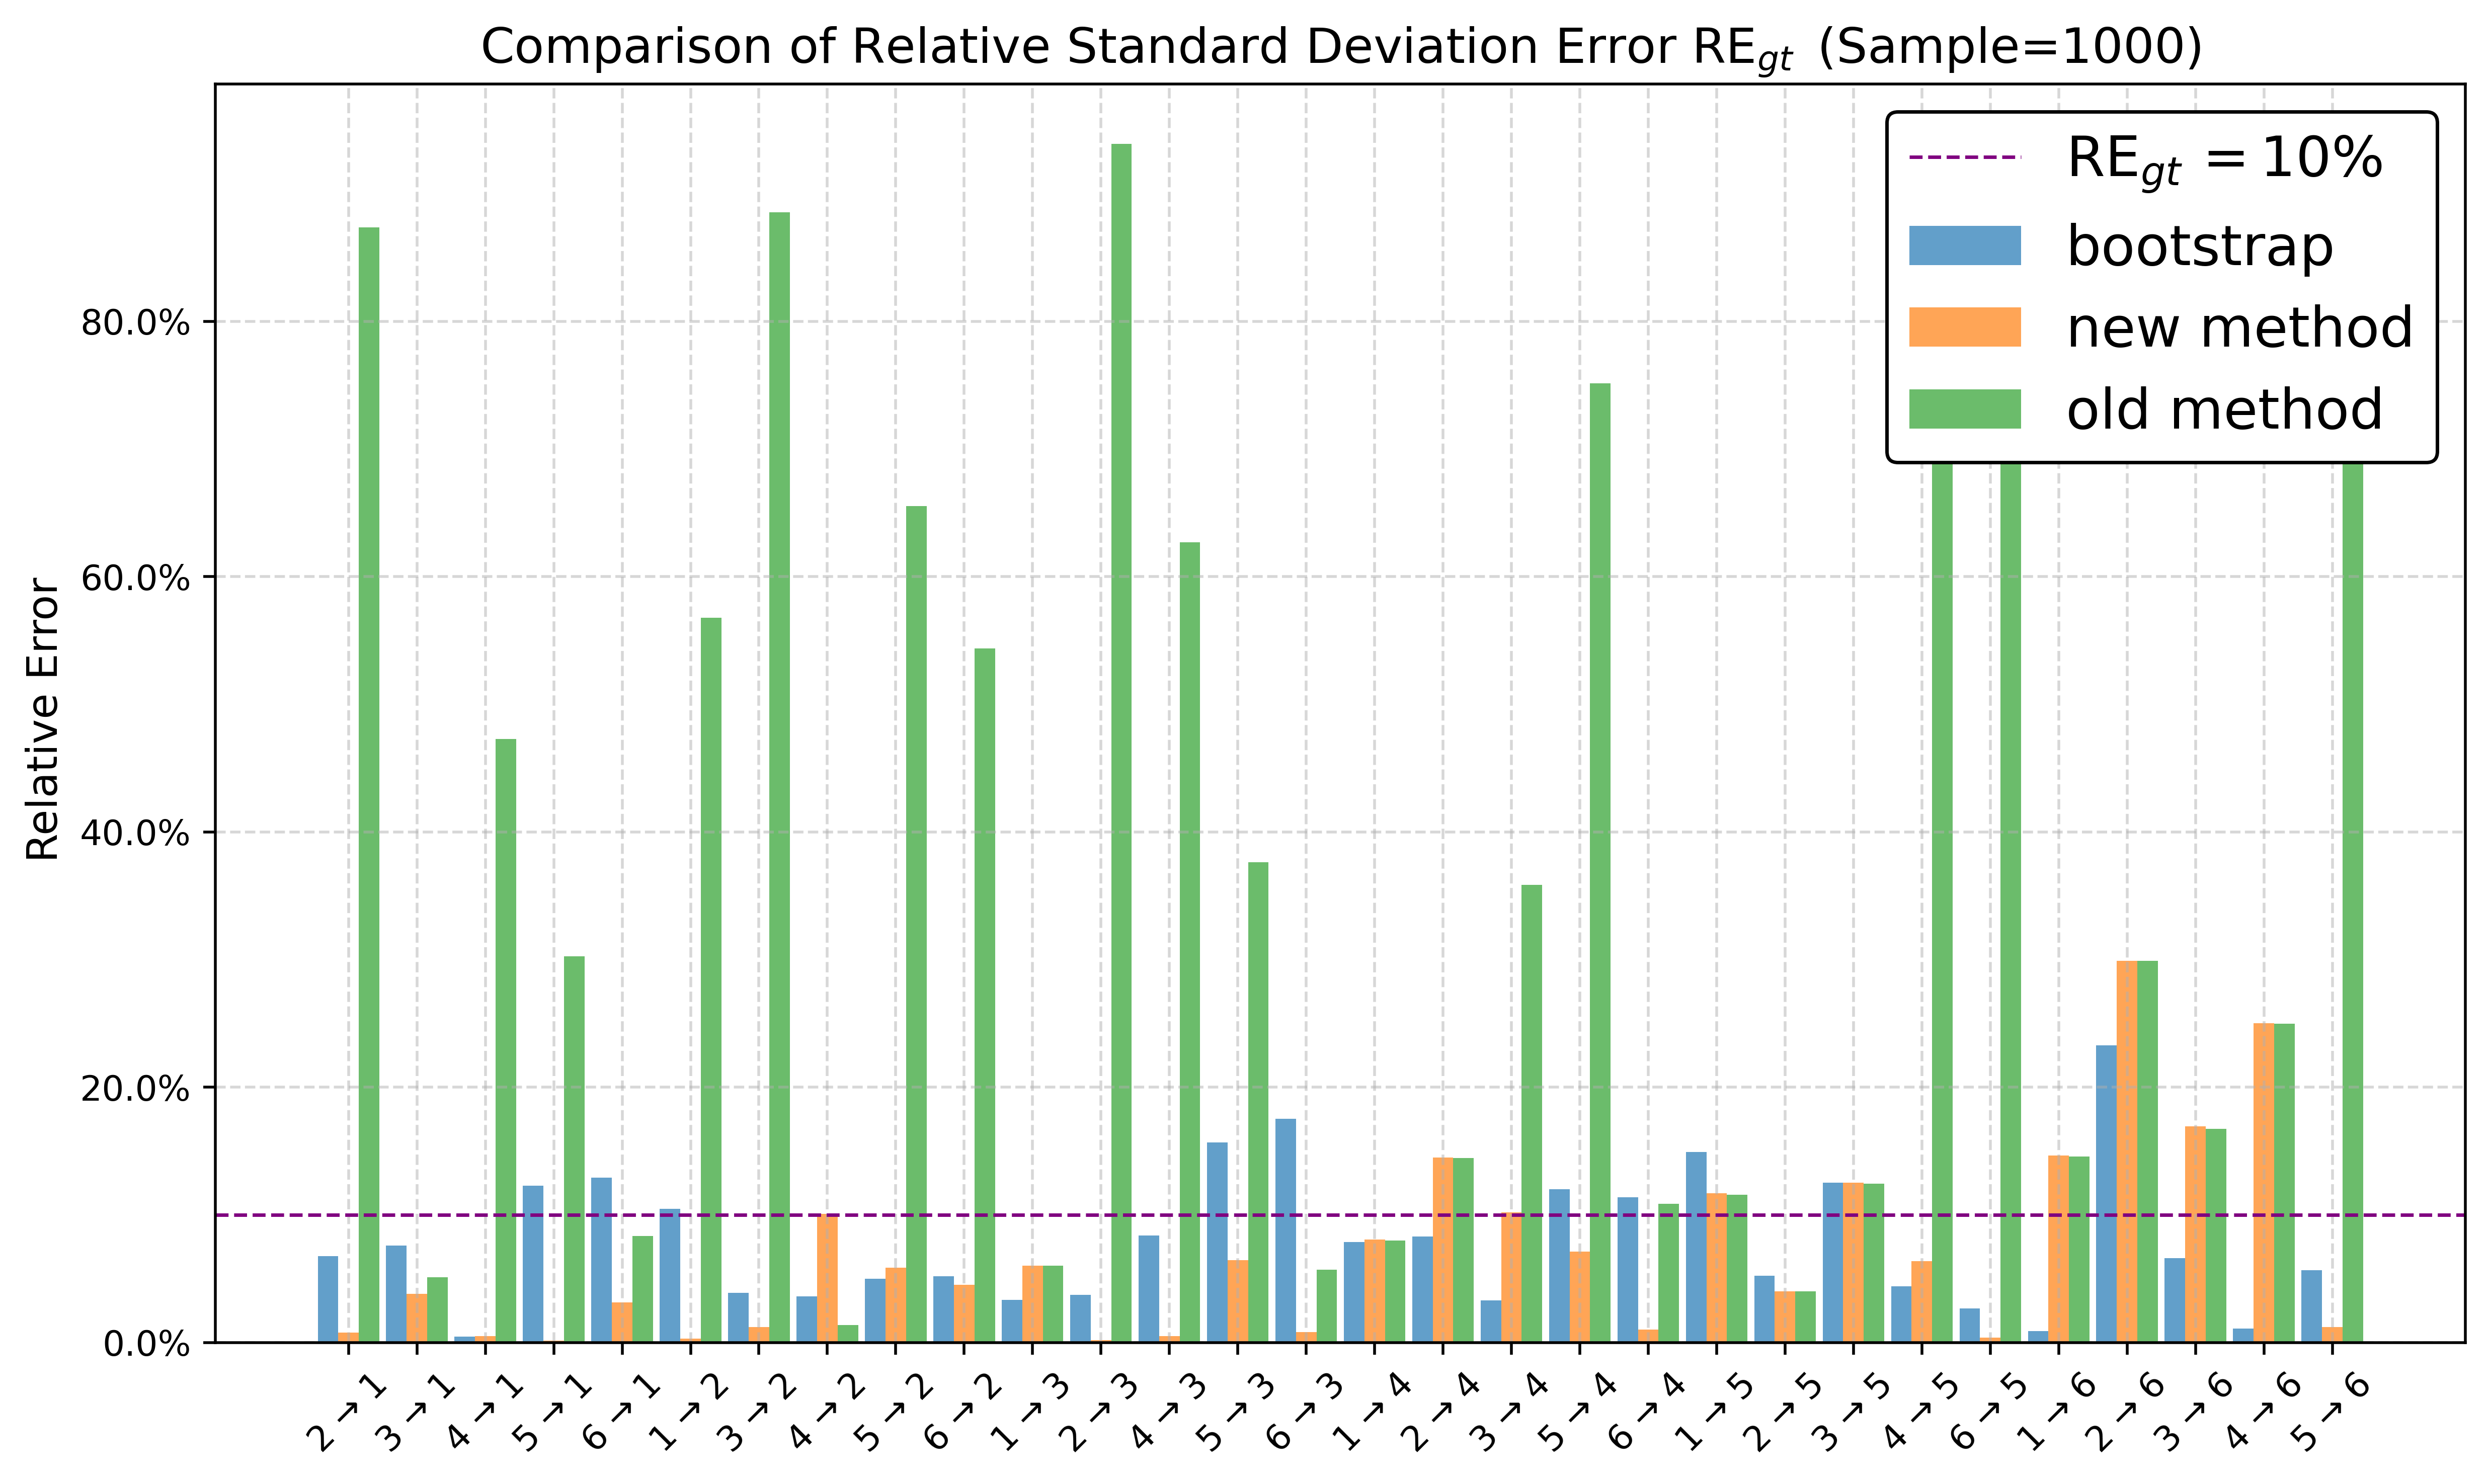

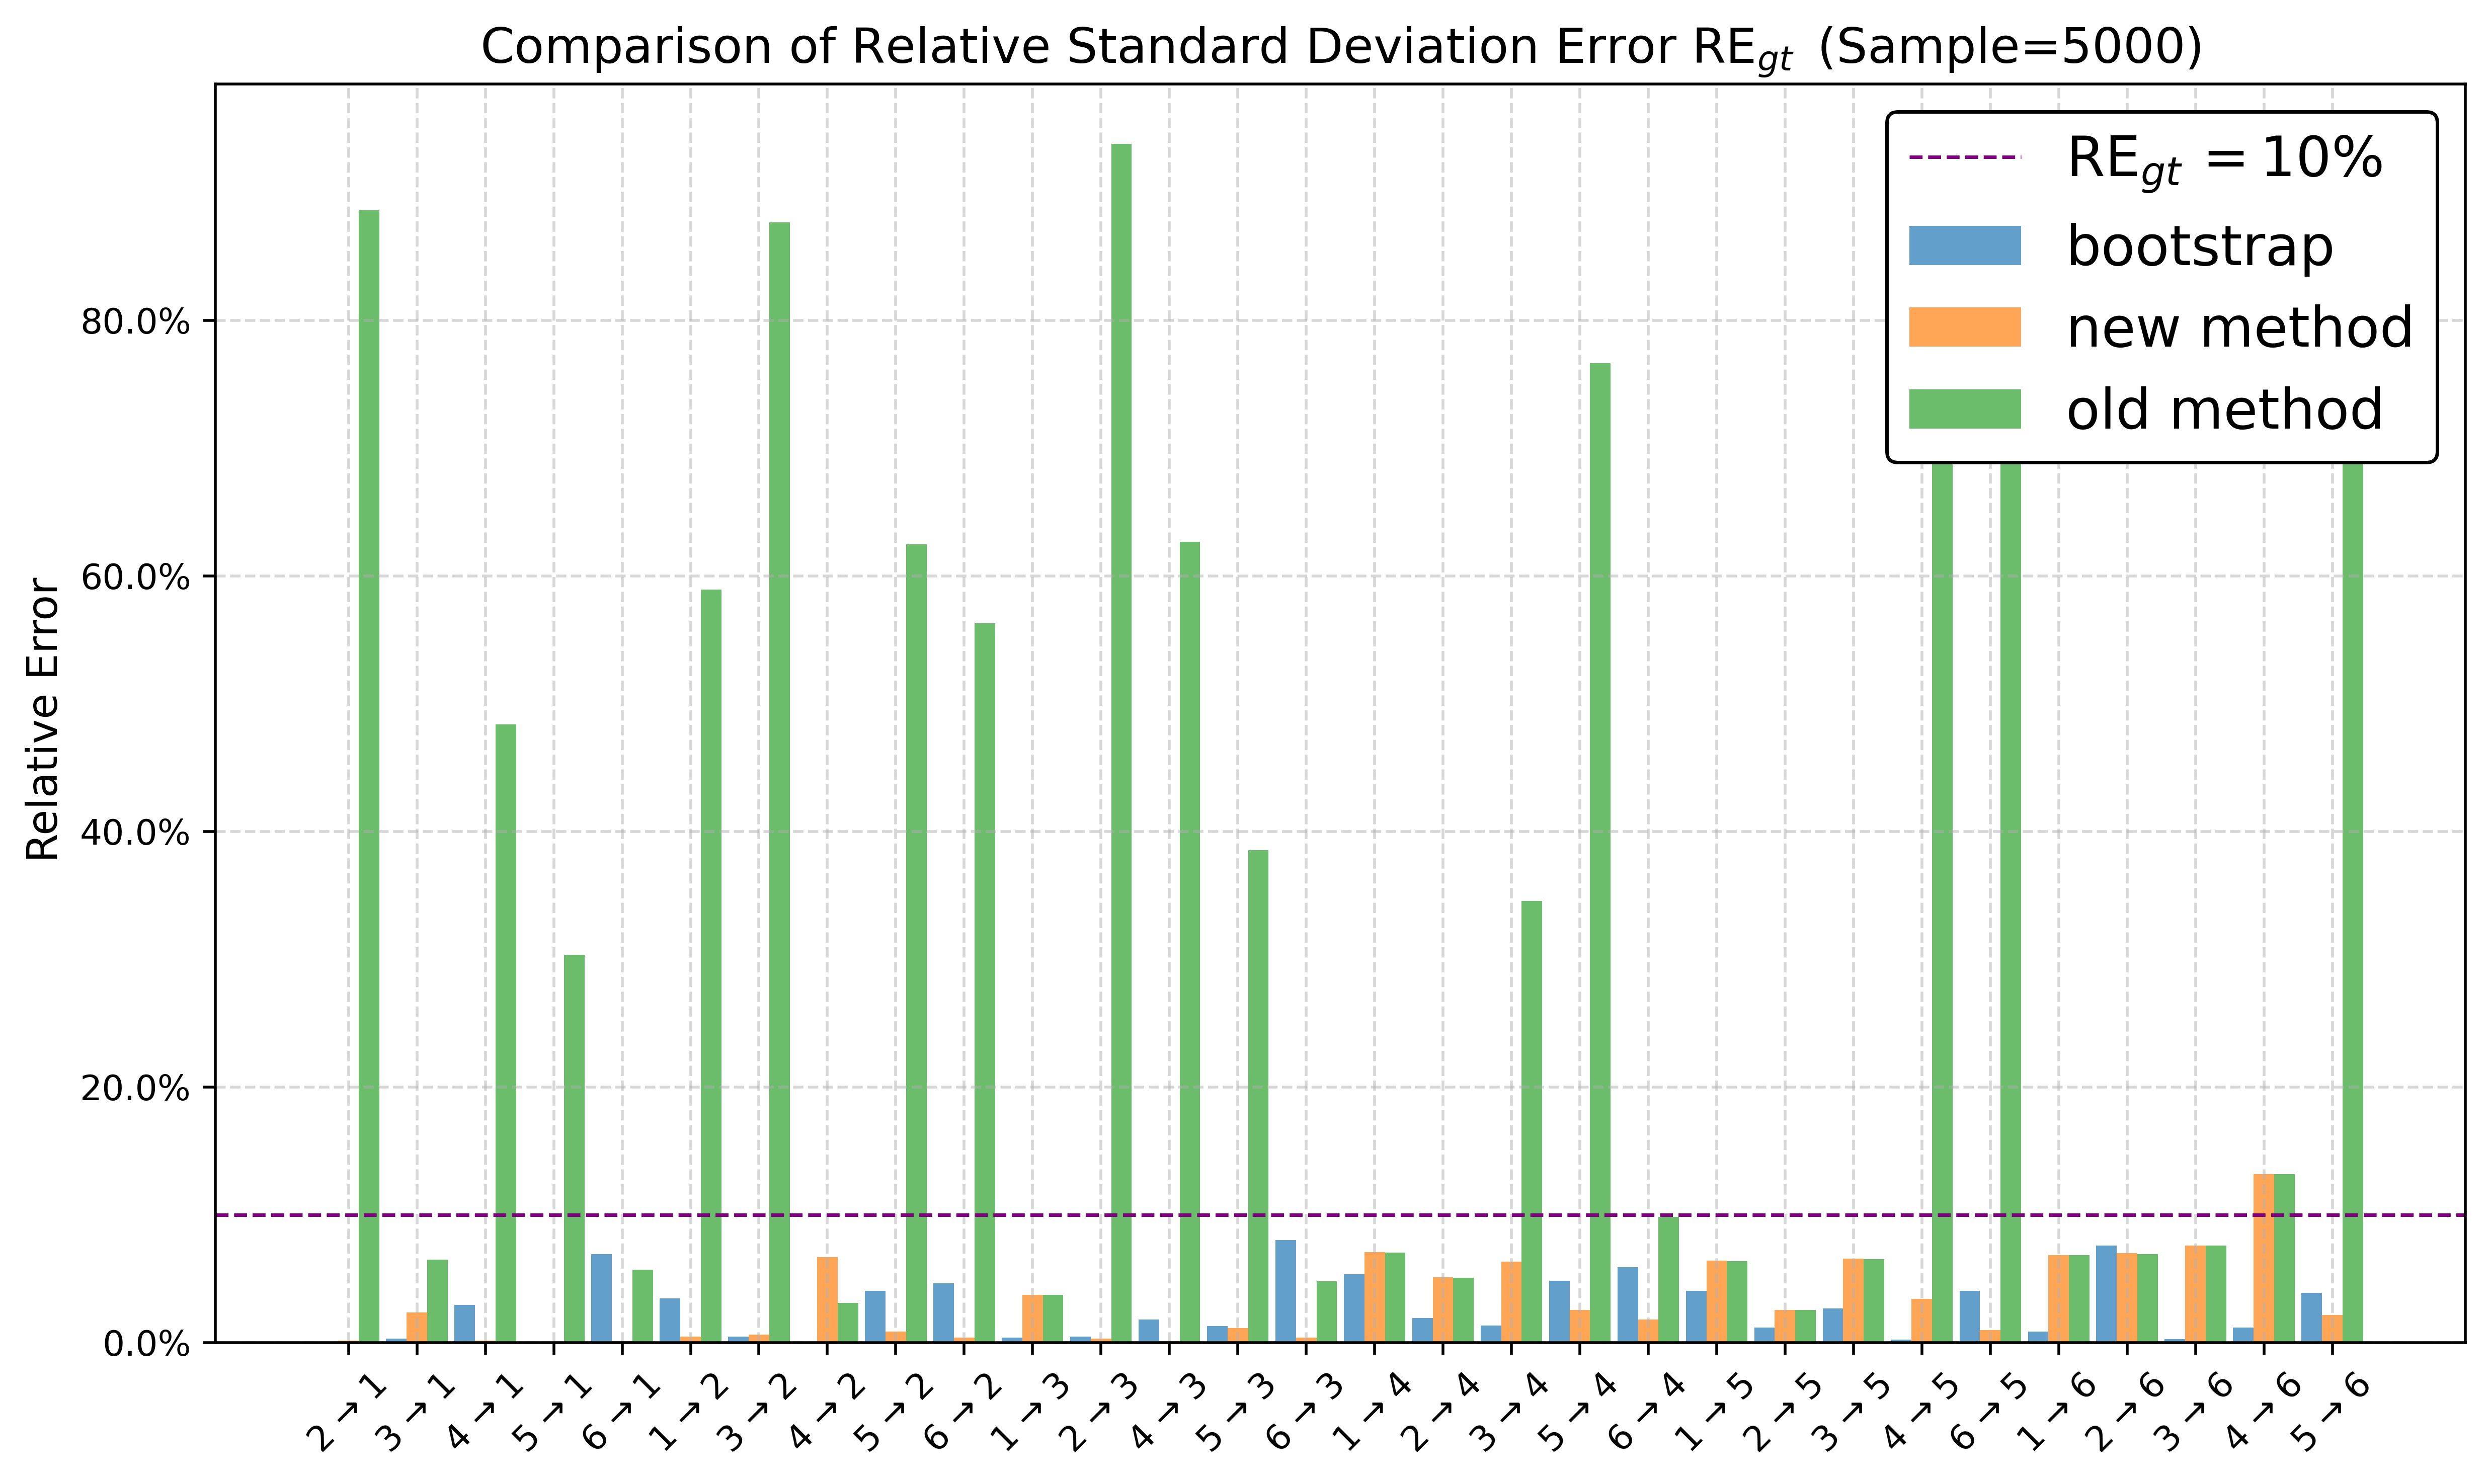

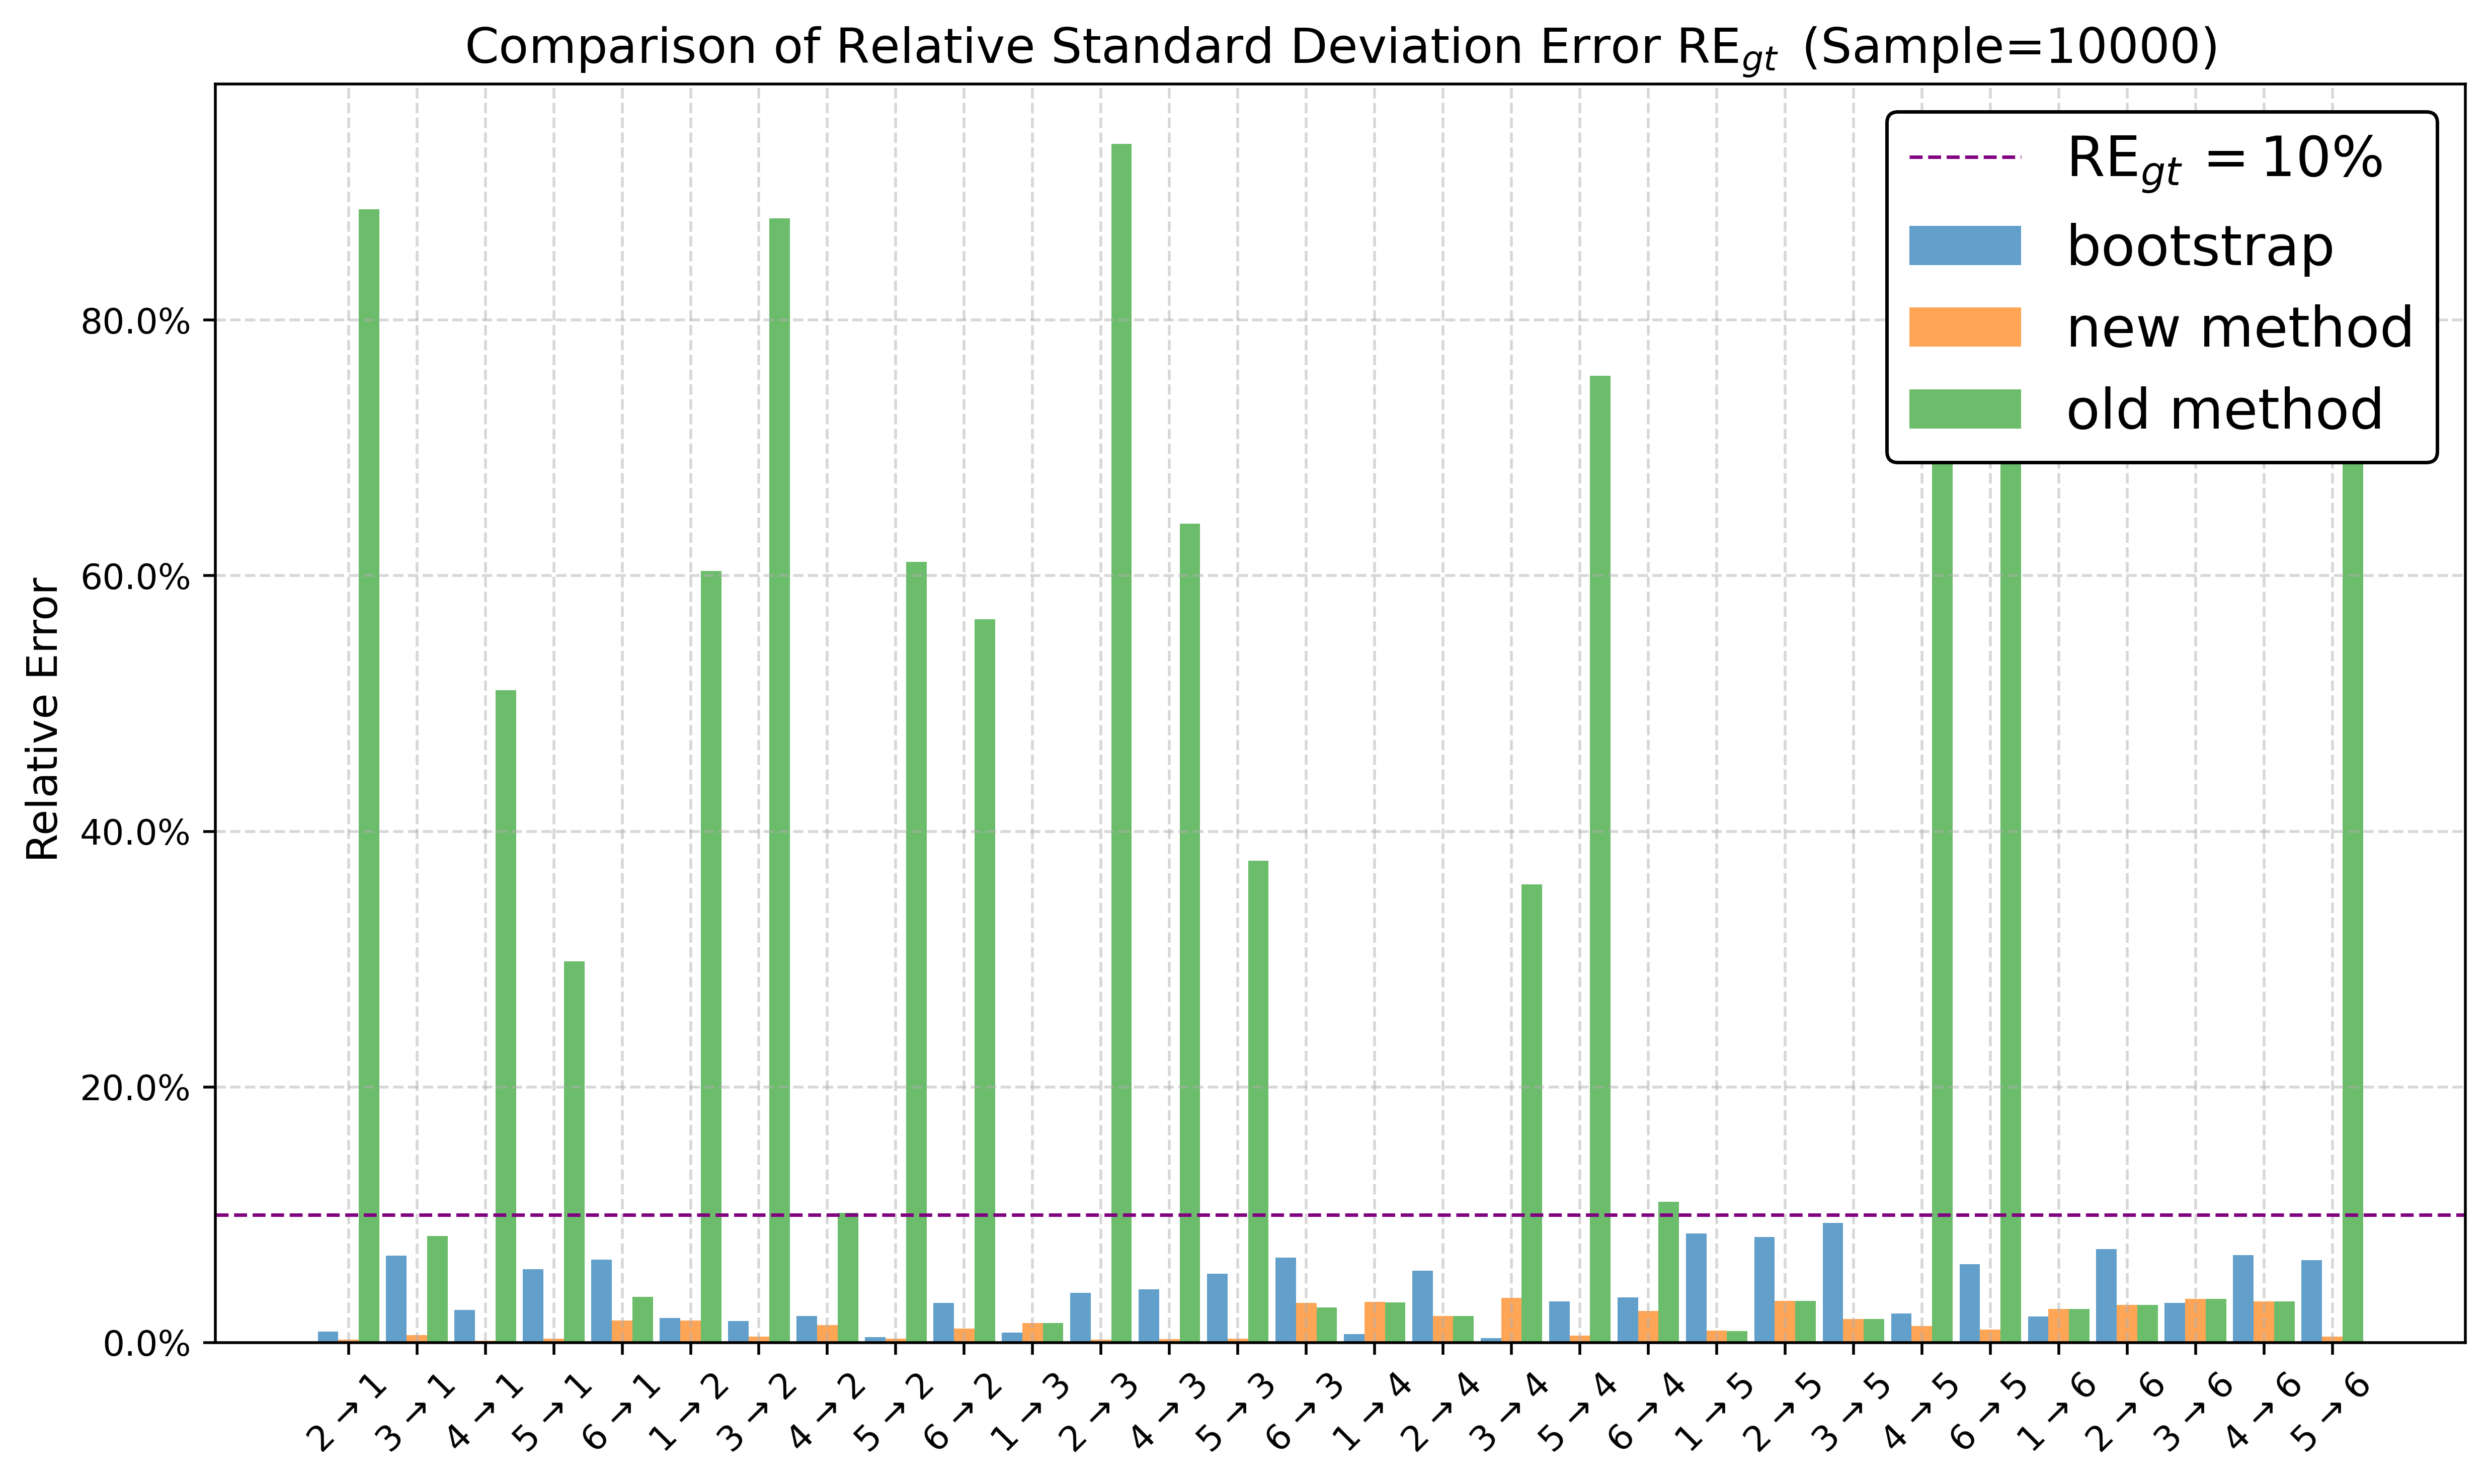

In [10]:
lkif_linear = LinearLKInformationFlow(dt)
for sample_num in [1000,5000,10000]:
    segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
    # segments = [(0,3),(3,6)]
    lkif_linear.causality_estimate([X[:,:sample_num].T], lag_list=[1], segments=segments, significance_test=True)
    result_dict = lkif_linear.get_dict()
    bootstrap_result = lkif_linear.bootstrap_estimate([X[:,-sample_num:].T], lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    real_information_flow = lkif_linear.real_information_flow_linear_case(A,B)
    
    filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
    filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
    filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
    filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

    # 计算相对误差
    y2 = (np.abs(filtered_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y3 = (np.abs(filtered_info_flow_std_origin - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std

  
    x = np.arange(len(y1))  # x 轴索引
    width = 0.3  # 柱子的宽度

    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    ax.bar(x - width, y1, width, label='bootstrap', alpha=0.7)
    ax.bar(x, y2, width, label='new method', alpha=0.7)
    ax.bar(x + width, y3, width, label='old method', alpha=0.7)

    # 添加 y=0.1 的虚线
    ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label=r"$\operatorname{RE}_{gt} = 10\%$")
    ax.set_title(r'Comparison of Relative Standard Deviation Error $\operatorname{RE}_{gt}$'+f' (Sample={sample_num})', fontsize=14)
    # ax.set_xlabel('Index')  # 添加 x 轴标签
    ax.set_ylabel('Relative Error ', fontsize=12)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
    ax.set_xticks(x)
    ax.set_xticklabels([f"{j} → {i}" for i, j in labels], rotation=45)
    # 设置标题和标签
    # ax.set_title(f'Relative Information Flow Standard Deviation Error Comparison (Sample={sample_num})', fontsize=14)
    # ax.set_xlabel('Index')  # 添加 x 轴标签

    # 添加图例，右上角
    ax.legend(loc='upper right', fontsize=16, frameon=True, framealpha=1, edgecolor="black", fancybox=True)


    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 显示图形
    plt.tight_layout()
    plt.savefig(f'figs/1_error_comparison_s_{sample_num}_b_{1000}.eps', format='eps')



Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/cy/5r03bcz51kn_f5cmtysf06lh0000gn/T/ipykernel_35933/3918230942.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sample Num", y="Value", data=df, palette="Set2", width=0.6)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


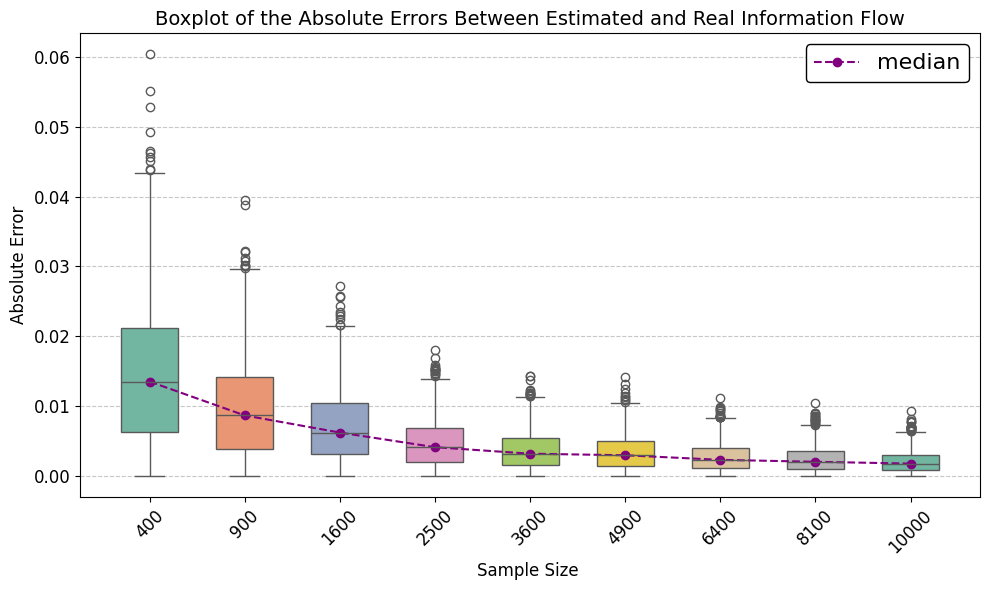

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 样本数
sample_sizes = np.array([20**2,30**2,40**2,50**2,60**2,70**2,80**2,90**2,100**2])
inv_sample_sizes = 1 / sample_sizes  # 1/sample_num

# 存储数据
y2_list, sample_num_list = [], []
# choose = []
for sample_num in sample_sizes:
    segments = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6)]
    
    # 计算信息流
    lkif_linear.causality_estimate([X[:,:sample_num].T], lag_list=[1], segments=segments, significance_test=True)
    bootstrap_result = lkif_linear.bootstrap_estimate([X[:,-sample_num:].T], lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    result_list = bootstrap_result["bootstrap_information_flow_list"]
    real_information_flow = lkif_linear.real_information_flow_linear_case(A, B, segments=segments)
    for item in result_list:
        y2_list.append(np.abs(item[0,1]-real_information_flow['information_flow'][0,1]))
    # 计算误差
    # filtered_info_flow = remove_diagonal(result_dict["information_flow"])
    # filtered_real_info_flow = remove_diagonal(real_information_flow["information_flow"])
    # y2 = np.abs(filtered_info_flow - filtered_real_info_flow)
    # choose.append(y2[5])

    # Flatten 并存储数据
    # y2_list.extend(y2.flatten())
    sample_num_list.extend([sample_num] * len(result_list))  # 记录样本数
# 组合数据
df = pd.DataFrame({"Value": y2_list, "Sample Num": sample_num_list})
df["Sample Num"] = df["Sample Num"].astype(str)  # 作为分类变量

# 计算每个 sample_num 的中位数
median_values = df.groupby("Sample Num")["Value"].median().reset_index()
median_values["Sample Num"] = median_values["Sample Num"].astype(int)  # 变回整数
median_values = median_values.sort_values("Sample Num")  # 按样本数排序

# 计算 sqrt(N)
sqrt_sample_sizes = np.sqrt(median_values["Sample Num"])
fit_params = np.polyfit(sqrt_sample_sizes, median_values["Value"], 1)  # 线性拟合 sqrt(N)
fit_curve = np.polyval(fit_params, sqrt_sample_sizes)  # 计算拟合值

# 画箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x="Sample Num", y="Value", data=df, palette="Set2", width=0.6)

# 绘制拟合曲线（基于 sqrt(N)）
plt.plot(median_values["Sample Num"].astype(str), median_values["Value"], "--", color="purple", marker="o", label="median")

# **调整 x 轴刻度**
plt.xticks(ticks=np.arange(len(sample_sizes)), labels=[f"{int(x)}" for x in sample_sizes], rotation=45, fontsize=12)

# 图表美化
plt.yticks(fontsize=12)
plt.title("Boxplot of the Absolute Errors Between Estimated and Real Information Flow", fontsize=14)
plt.ylabel("Absolute Error", fontsize=12)
plt.xlabel("Sample Size ", fontsize=12)
plt.legend(loc='upper right', fontsize=16, frameon=True, framealpha=1, edgecolor="black", fancybox=True)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f'figs/mean.eps', format='eps')


In [12]:
labels2 = [
(r'$\alpha_2$',r'$\alpha_1$'), (r'$\alpha_3$',r'$\alpha_1$'), 
(r'$\alpha_1$',r'$\alpha_2$'), (r'$\alpha_3$',r'$\alpha_2$'),
(r'$\alpha_1$',r'$\alpha_3$'), (r'$\alpha_2$',r'$\alpha_3$')]

Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bootstrap Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


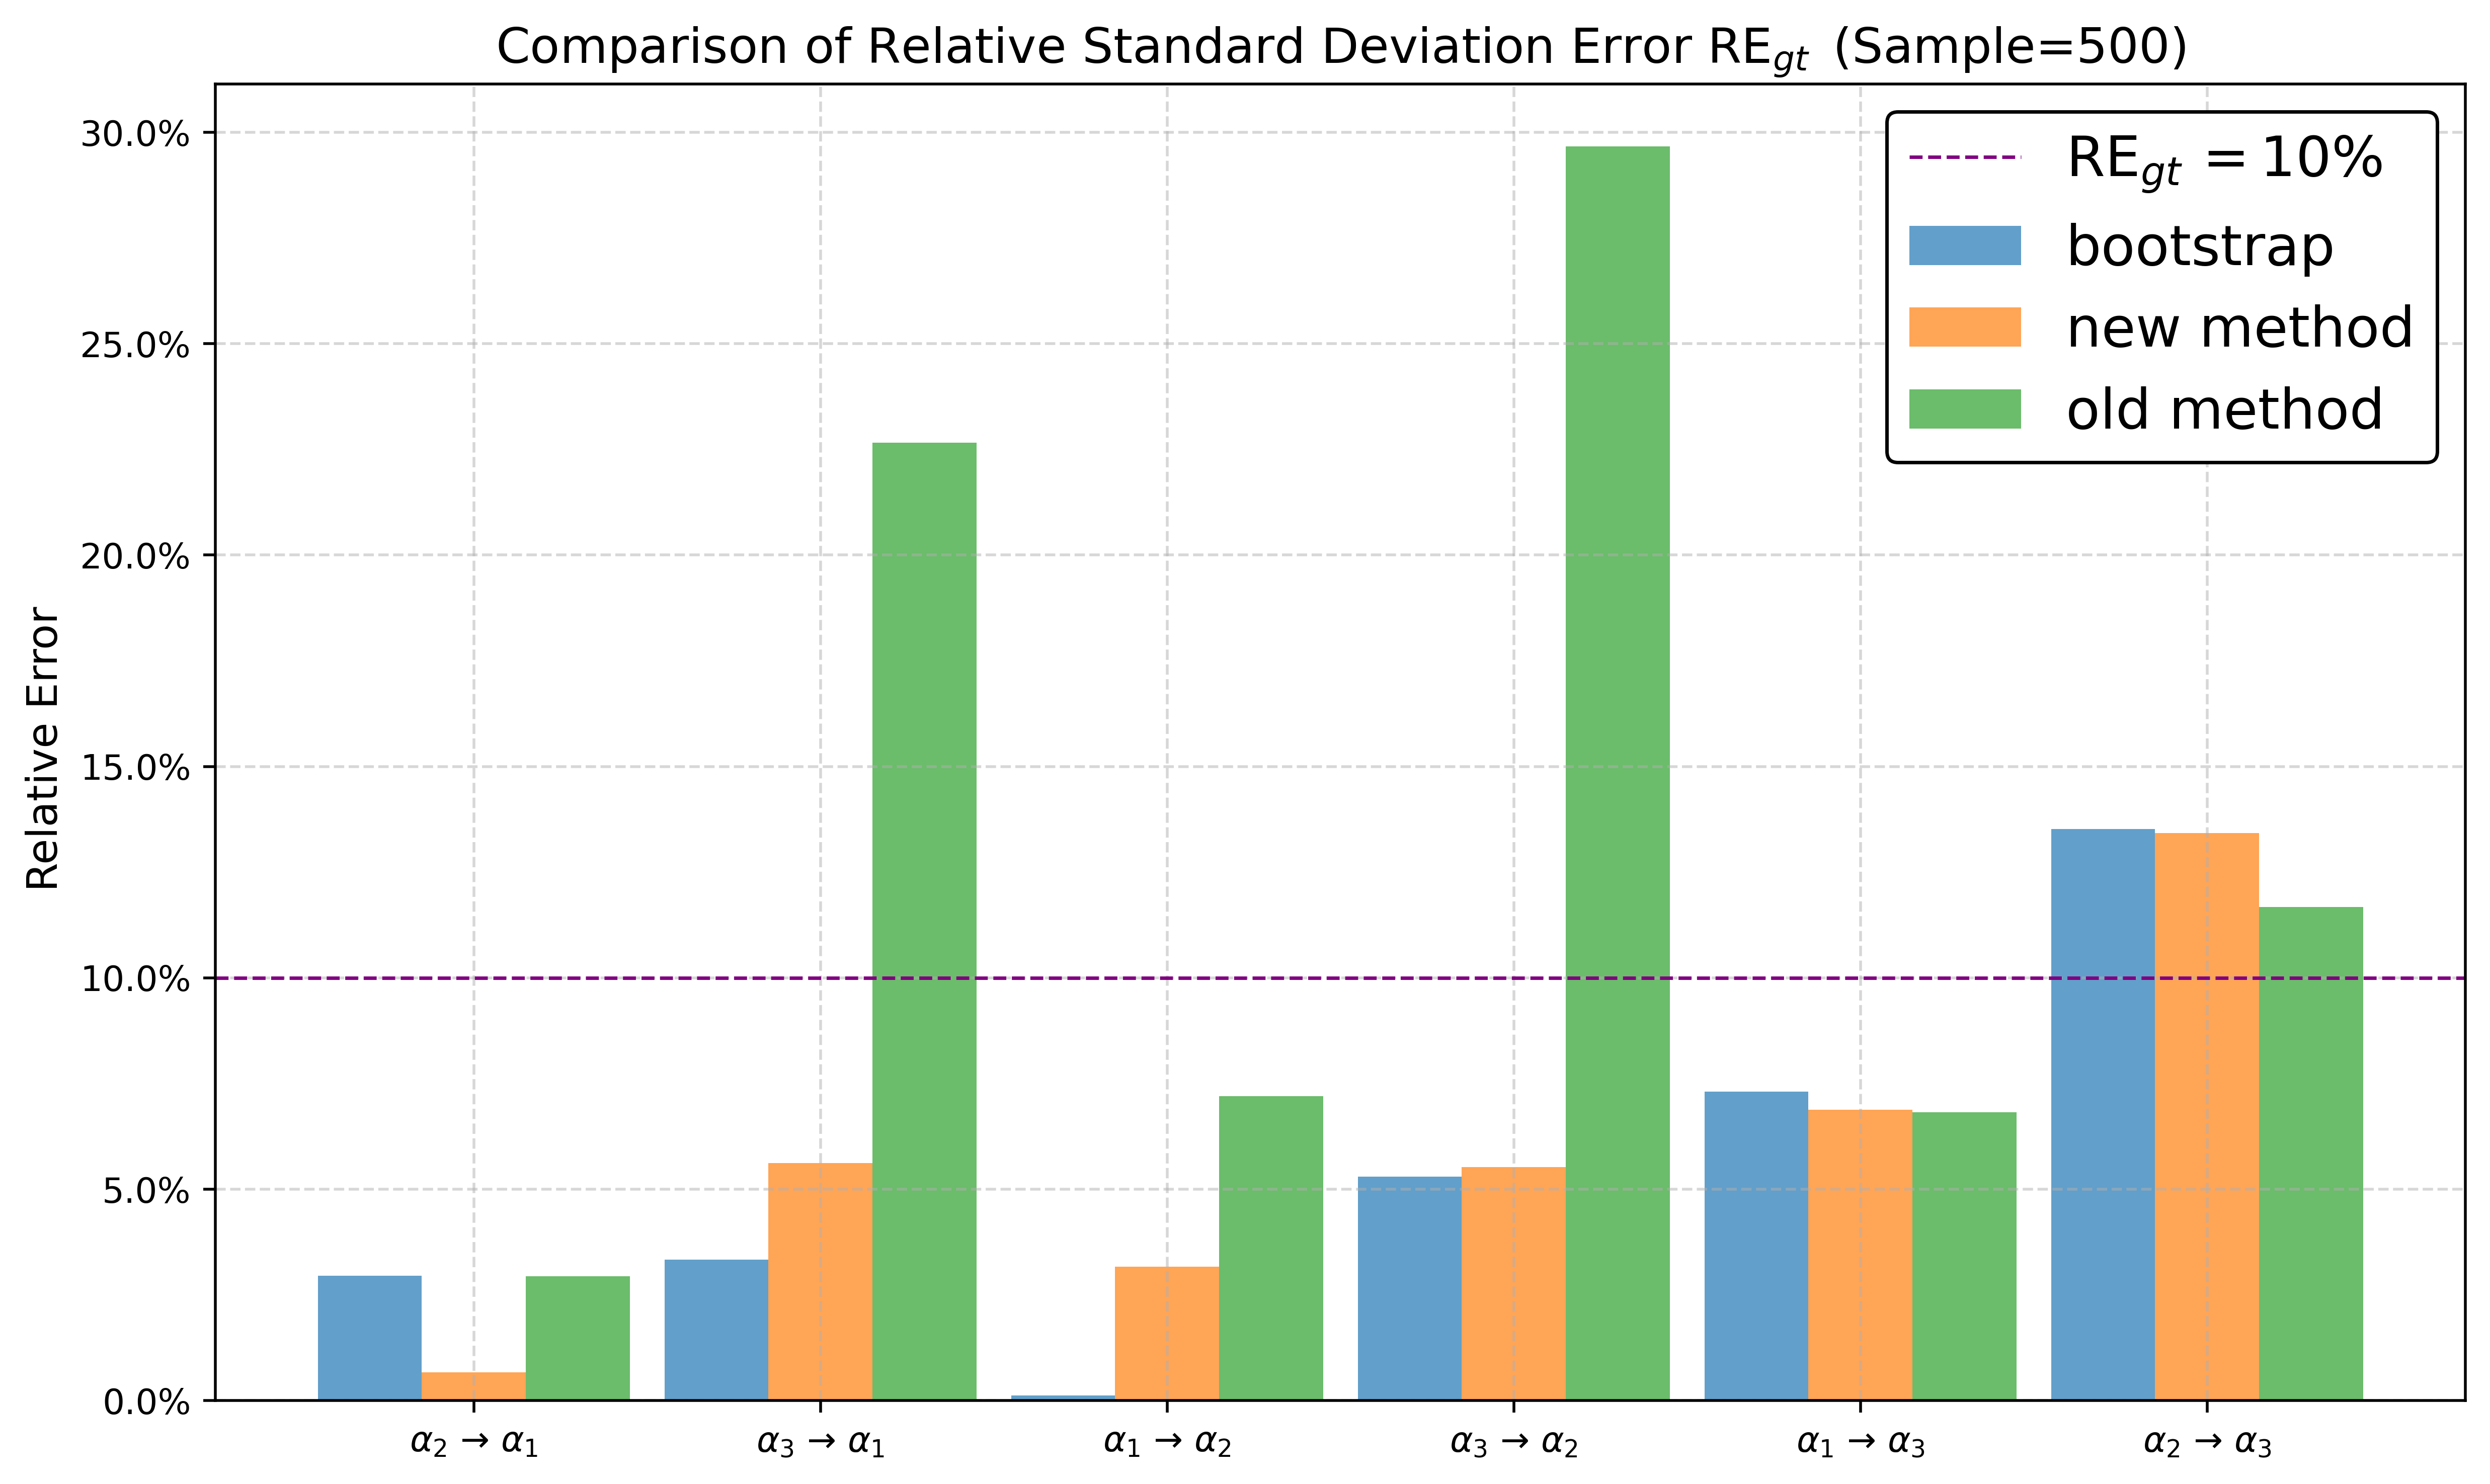

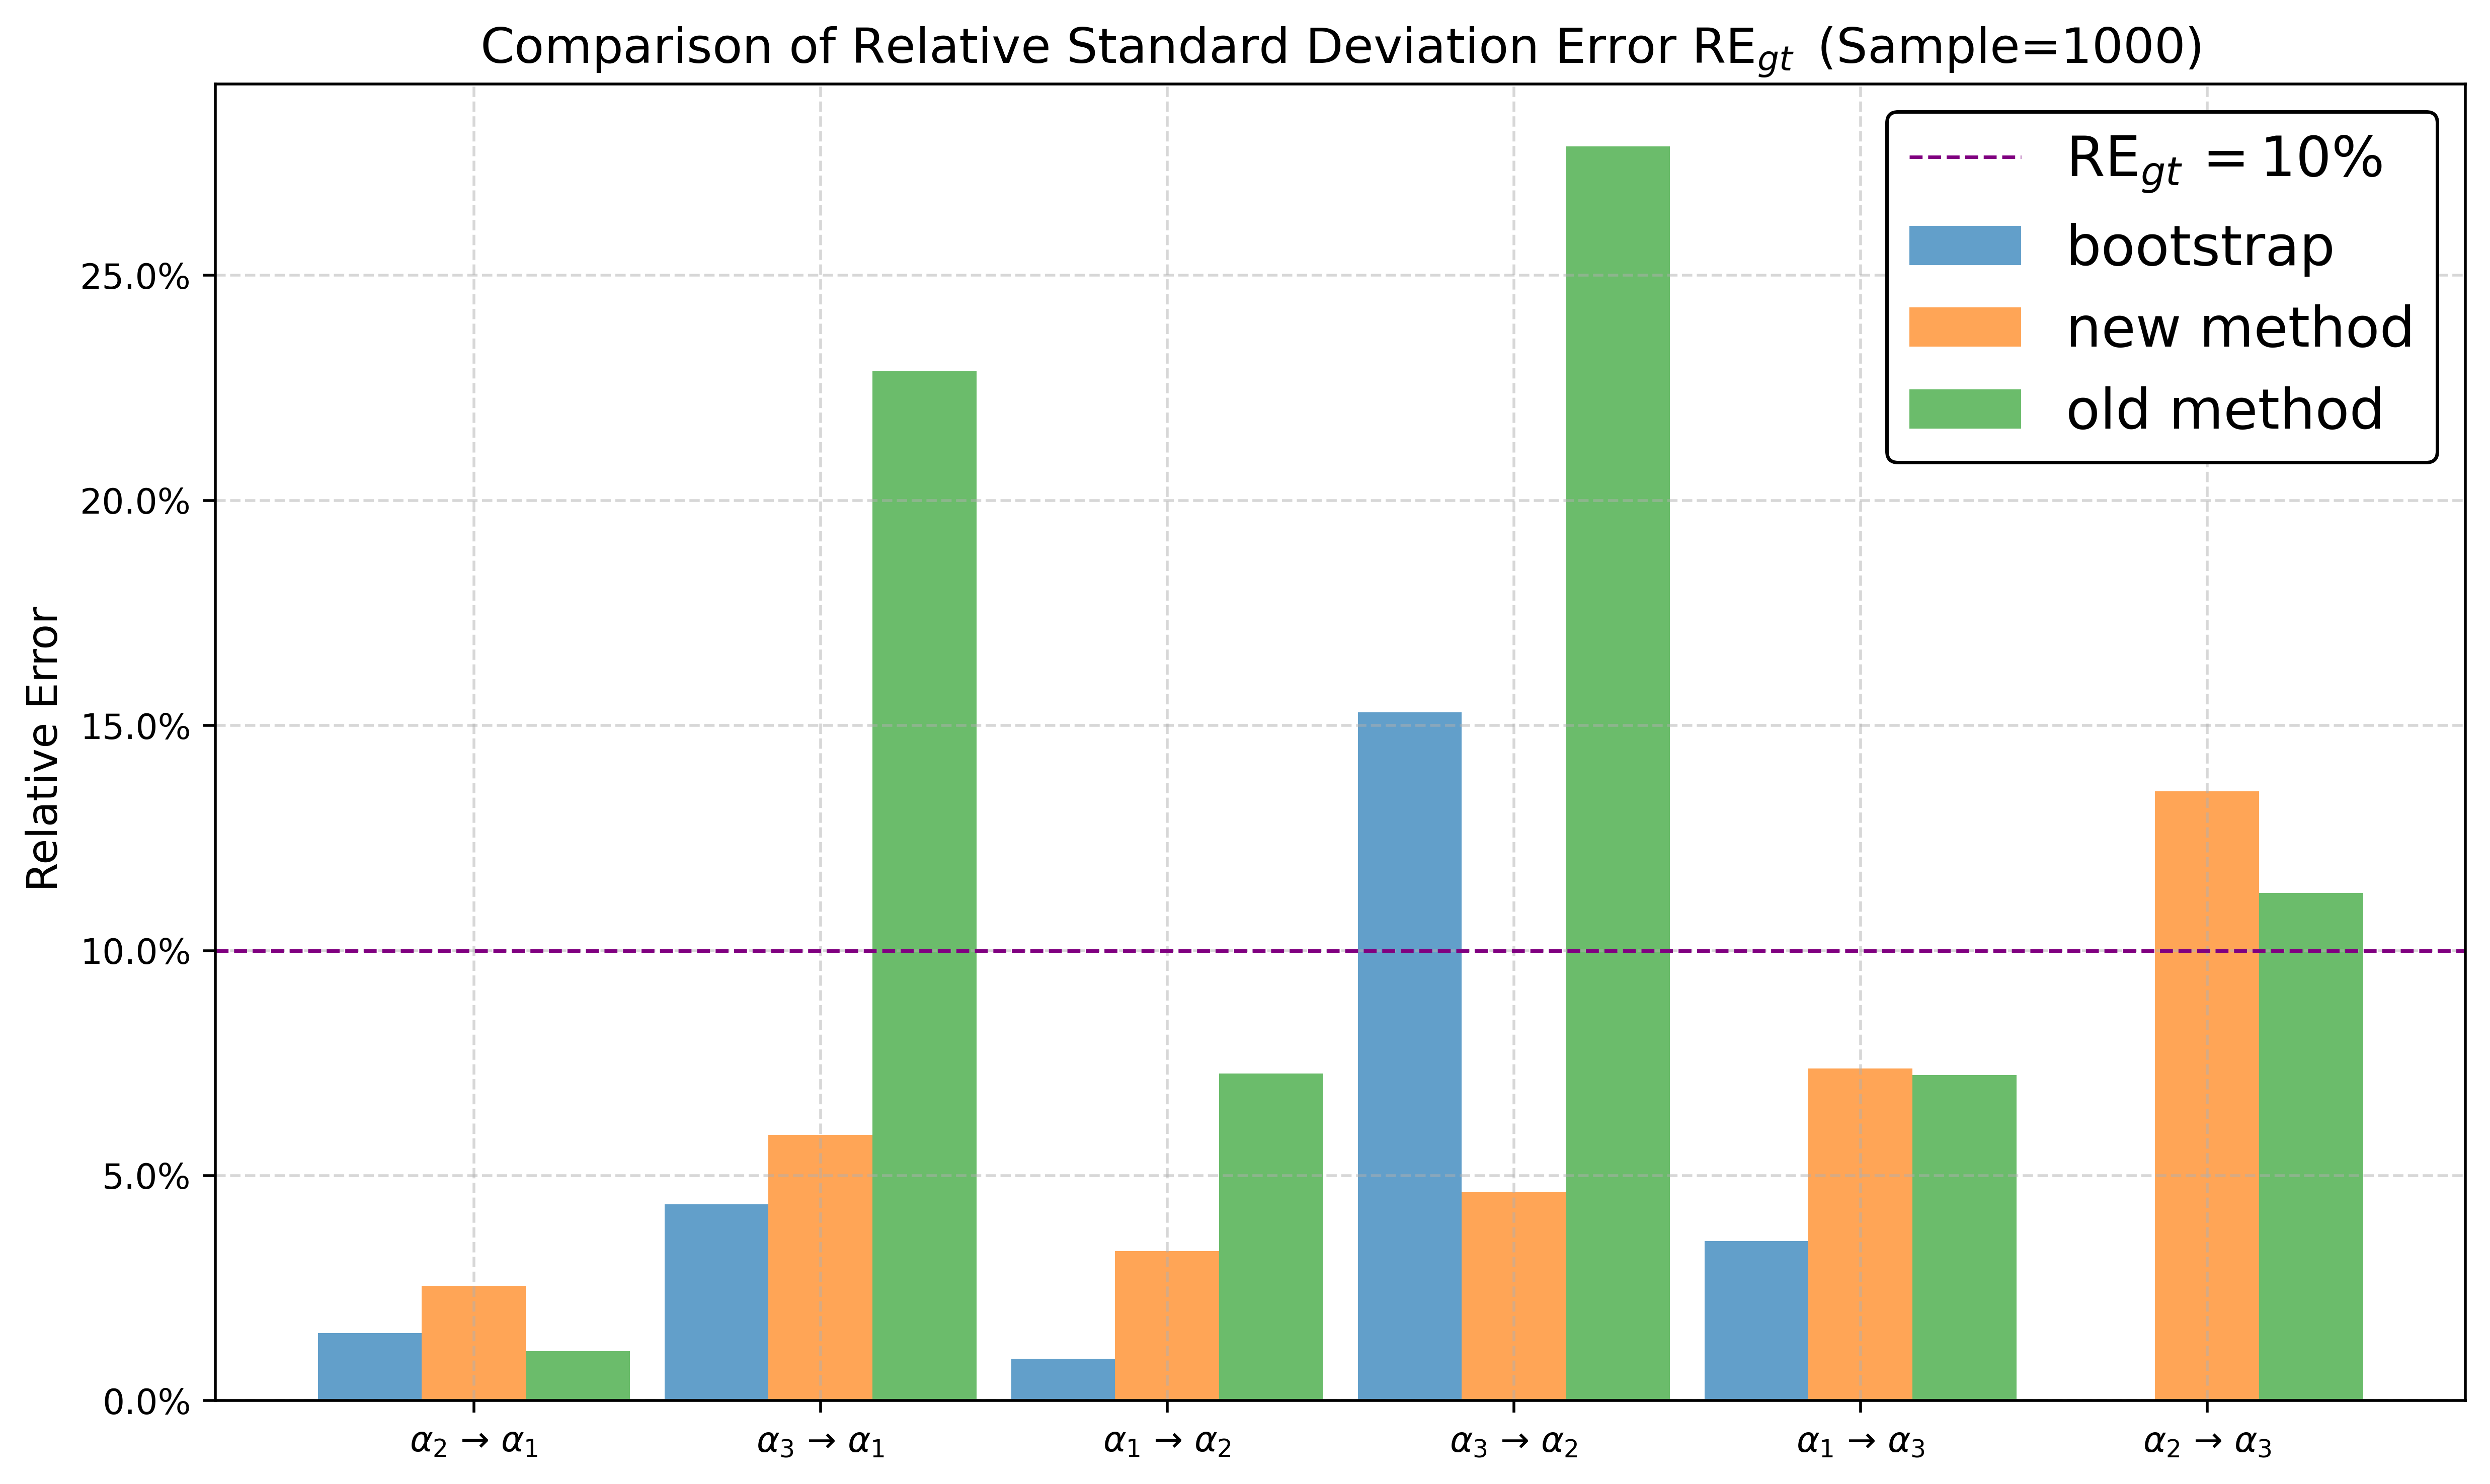

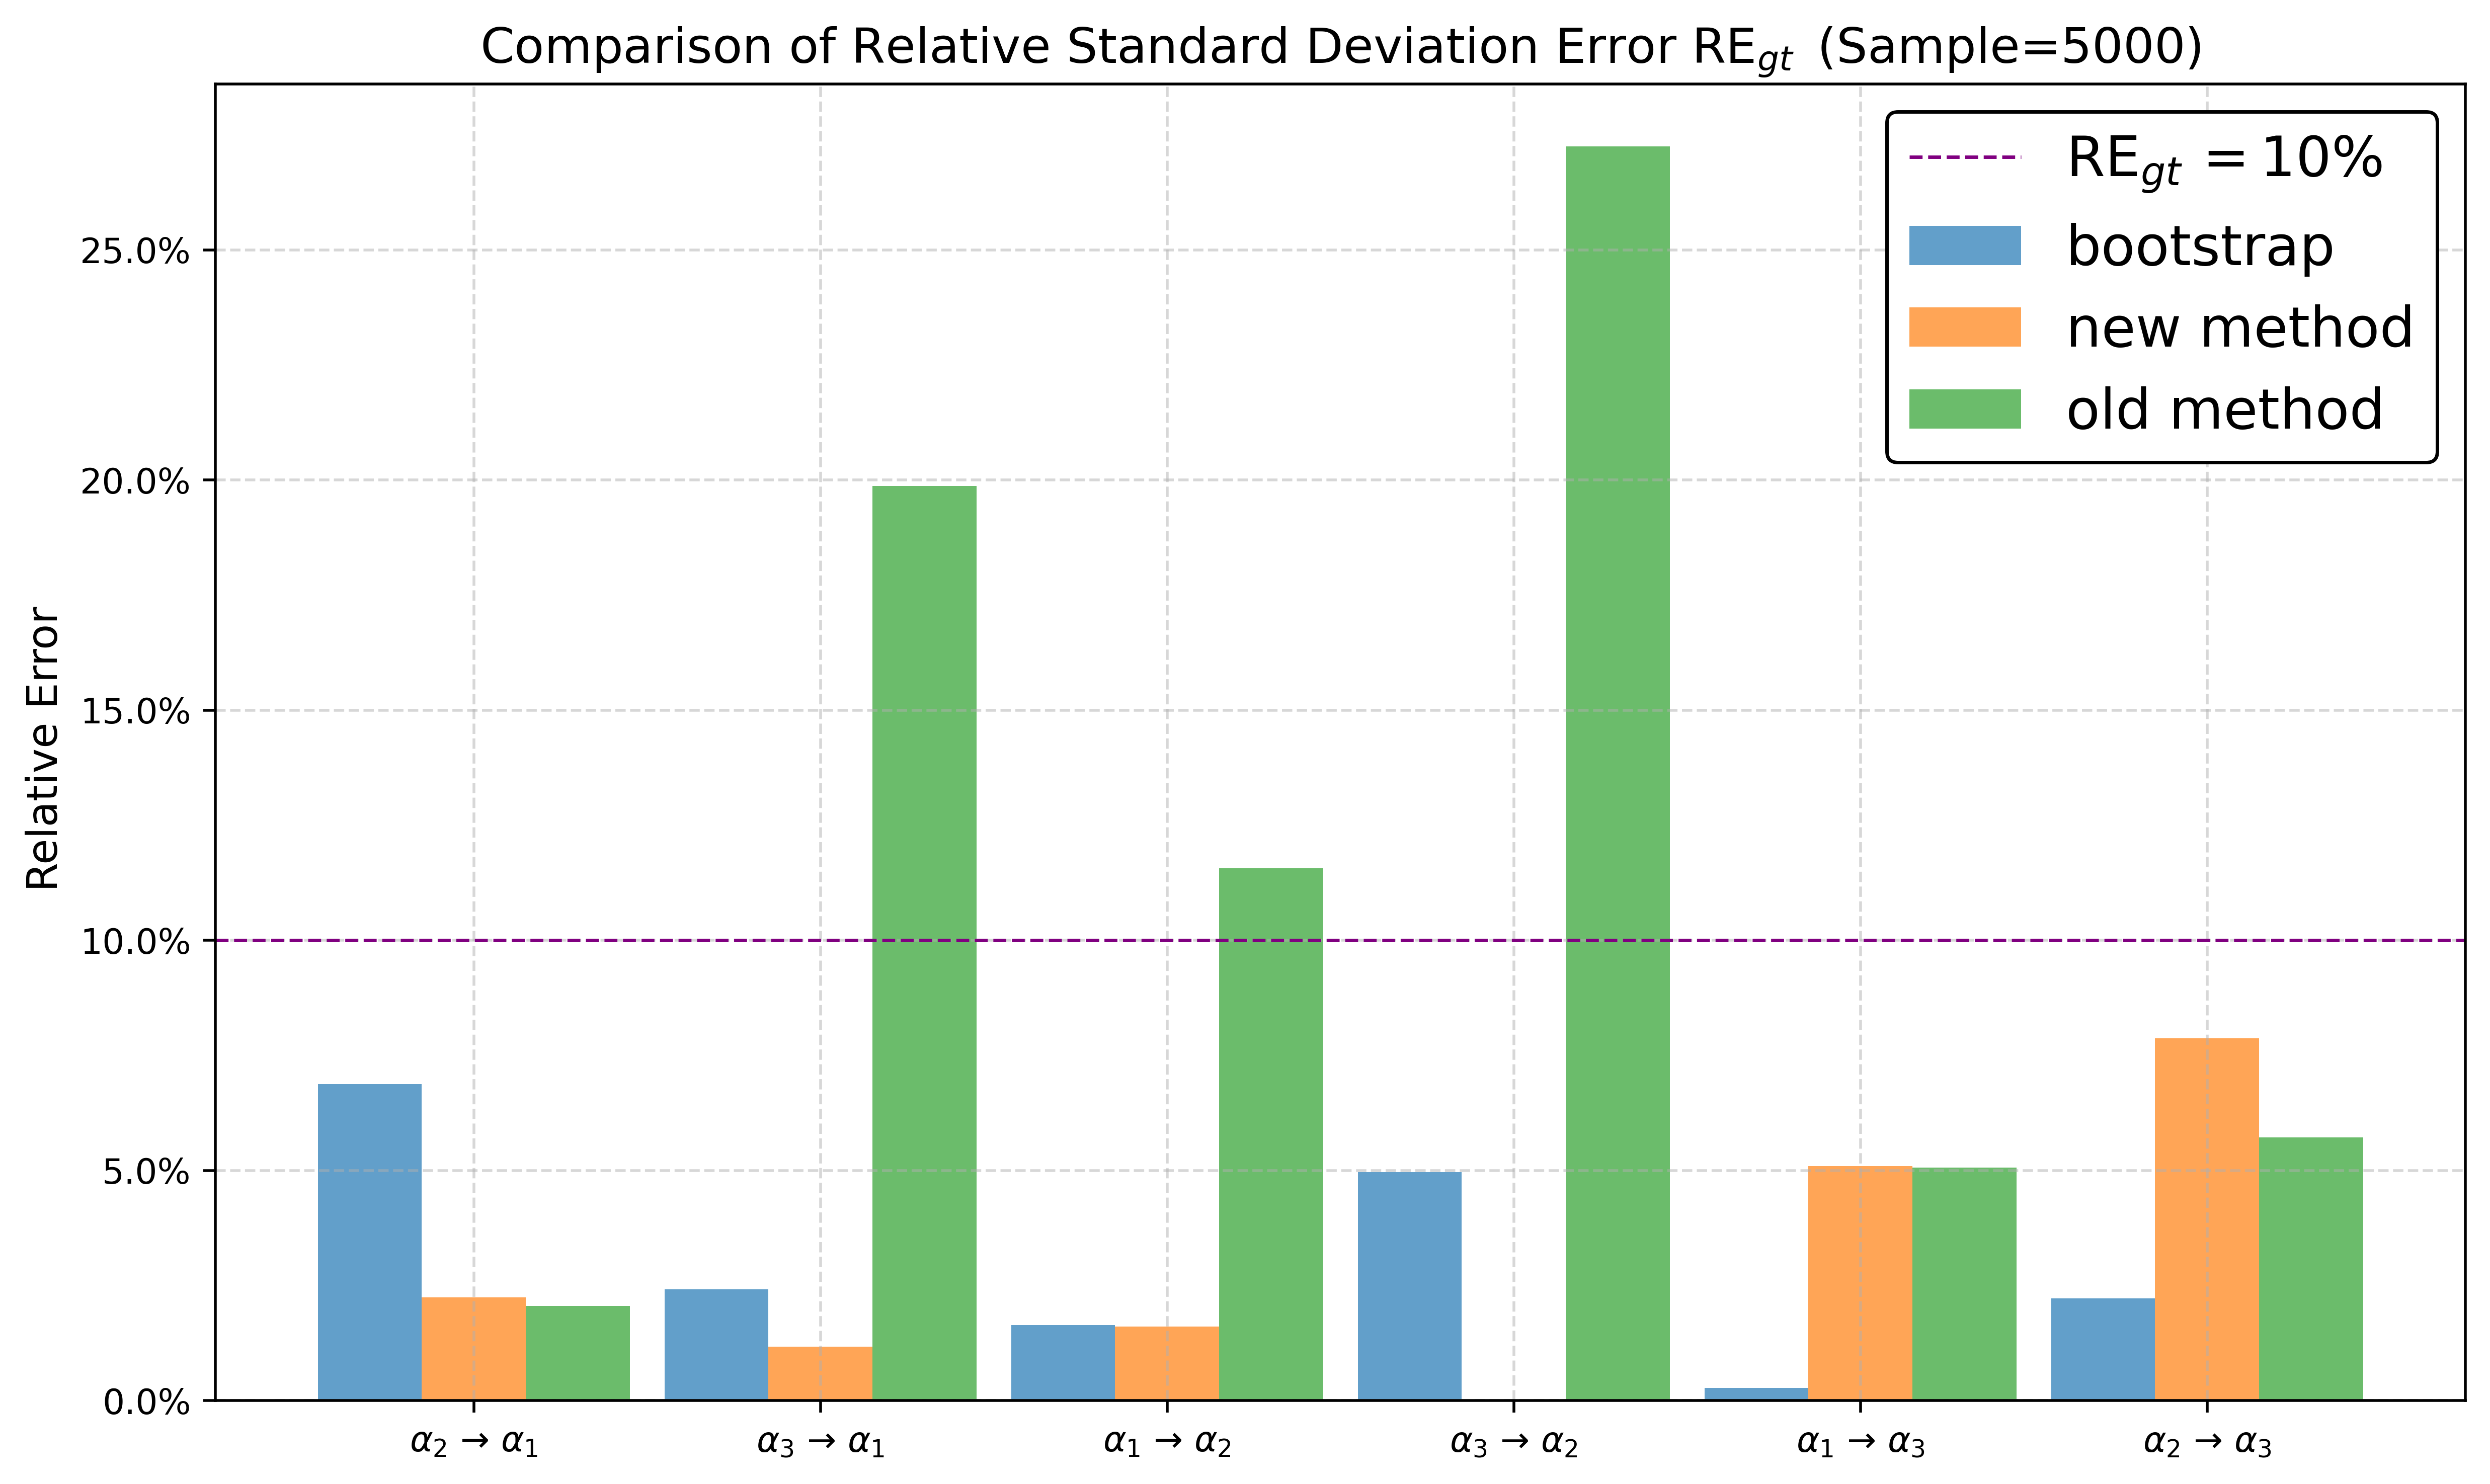

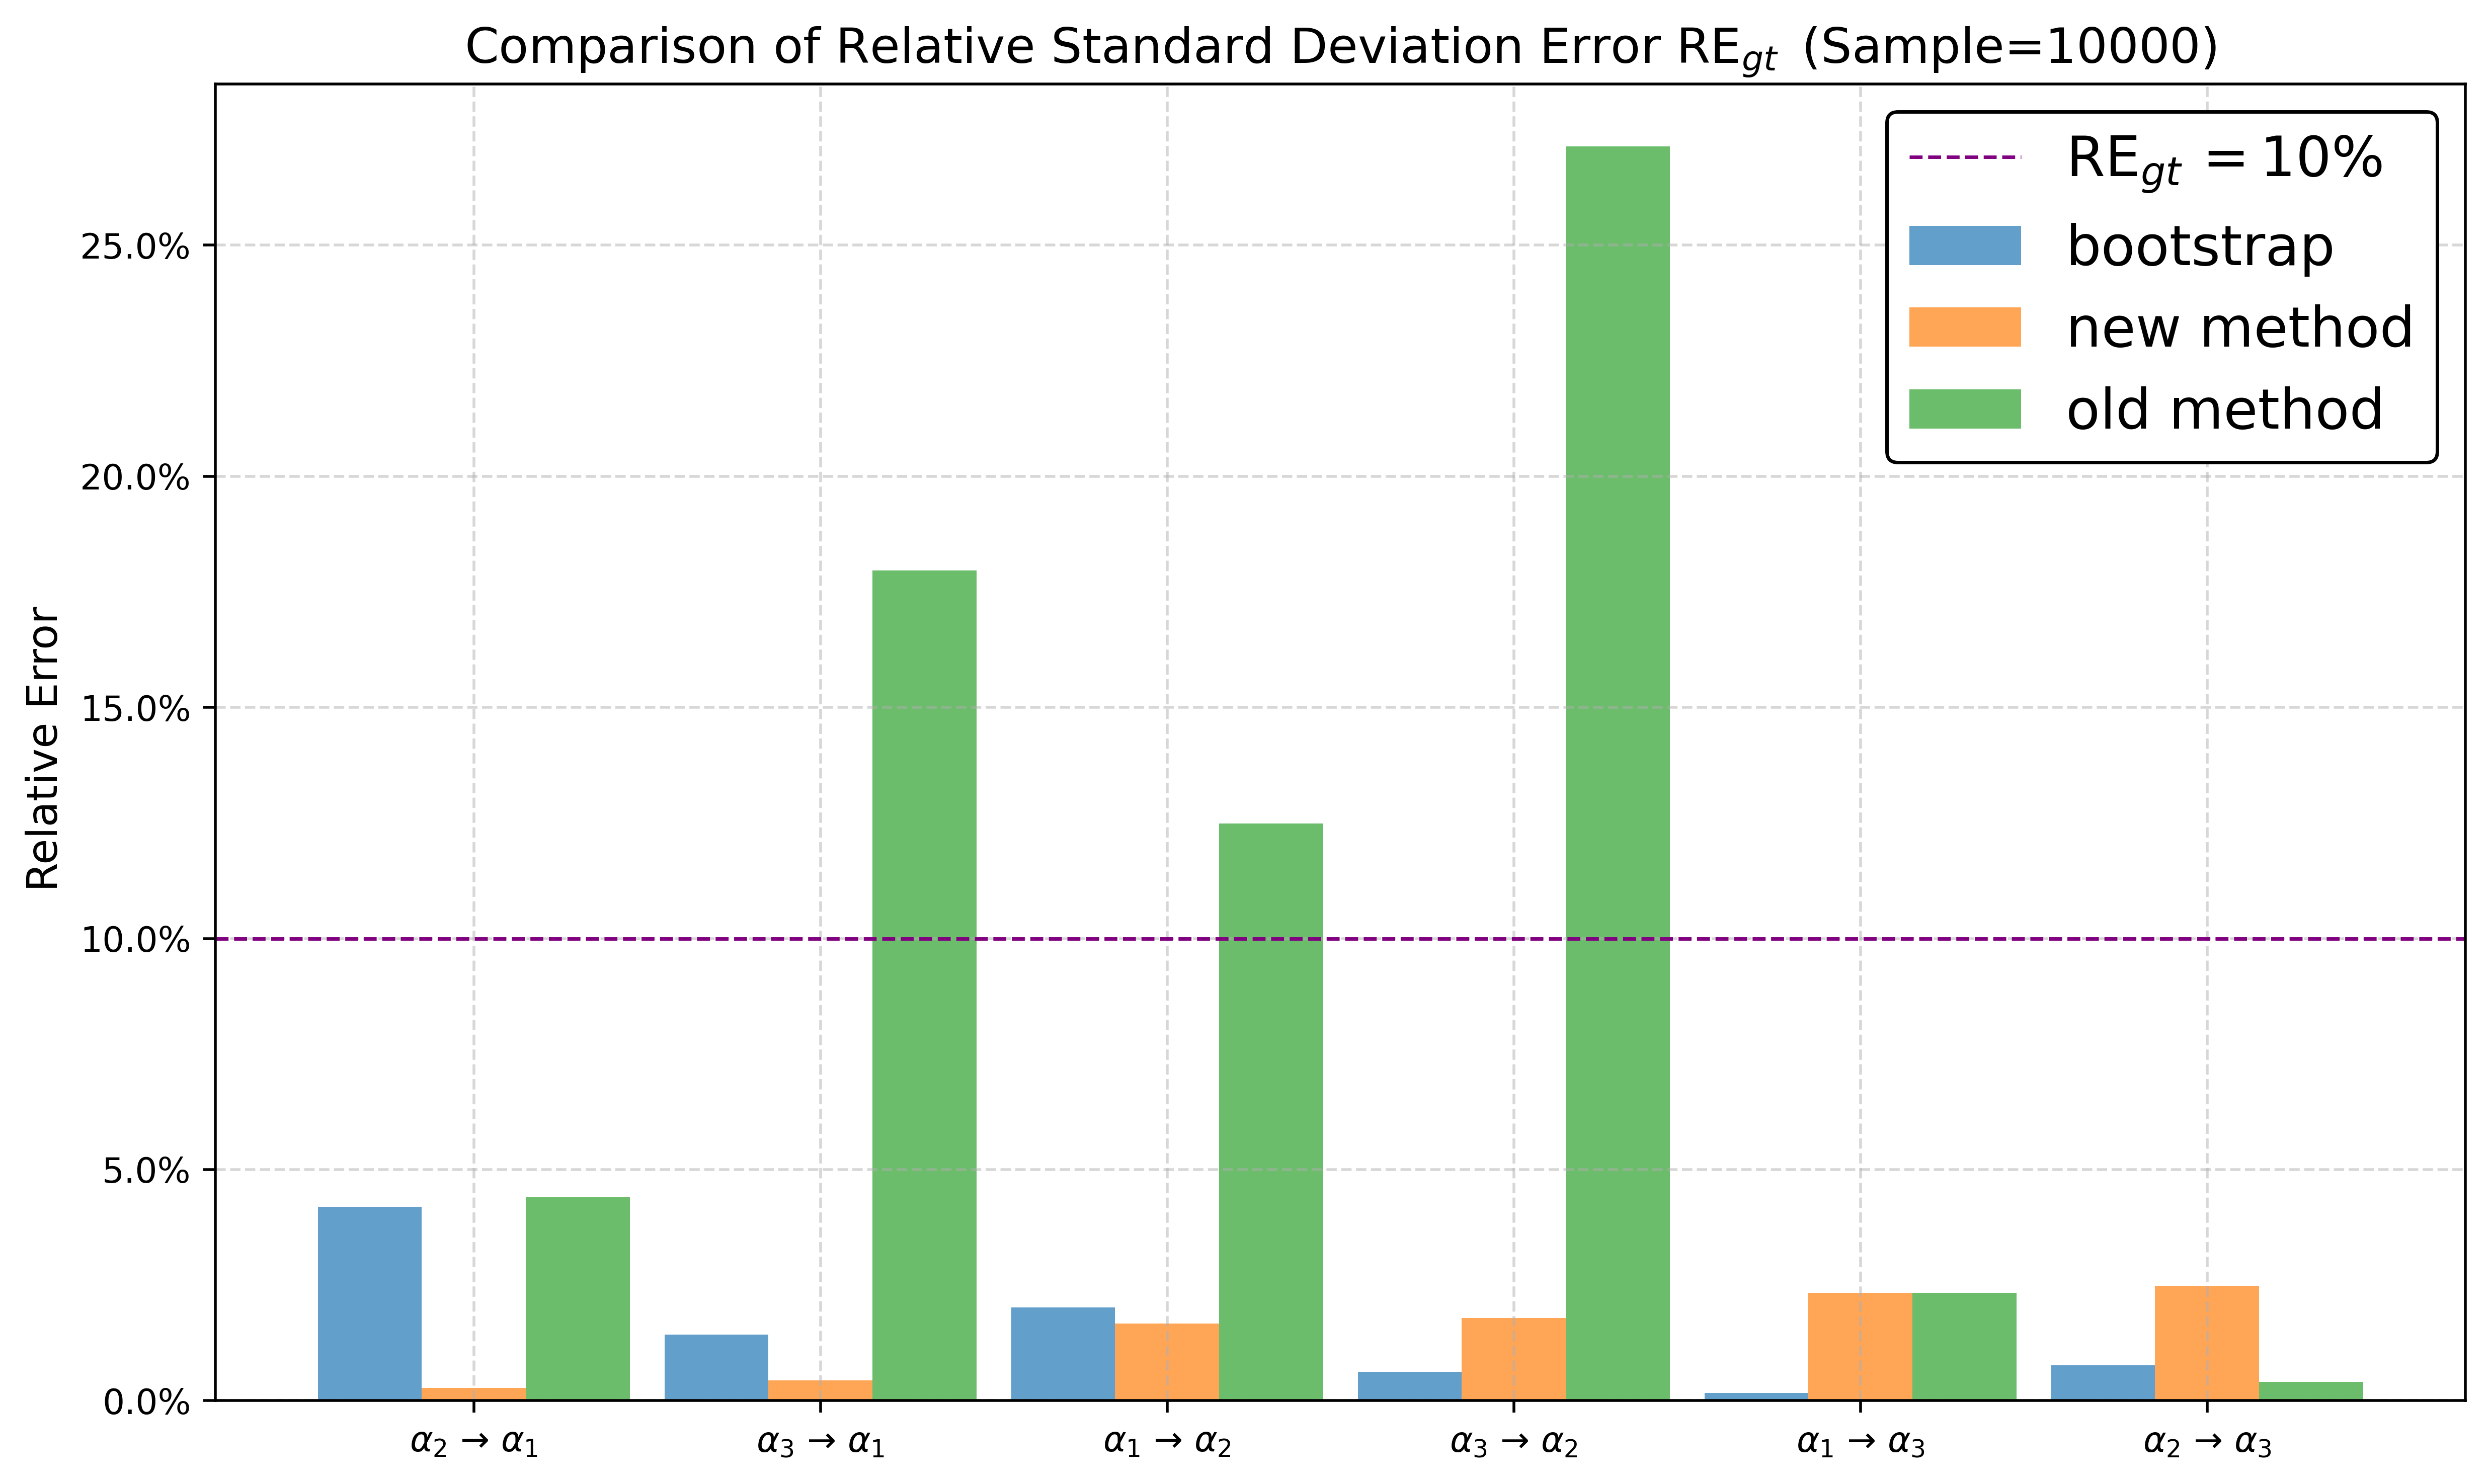

In [13]:
lkif_linear = LinearLKInformationFlow(dt)
for sample_num in [500,1000,5000,10000]:
    segments = [(0,2),(2,4),(4,6)]
    # segments = [(0,3),(3,6)]
    lkif_linear.causality_estimate([X[:,:sample_num].T], lag_list=[1], segments=segments, significance_test=True)
    result_dict = lkif_linear.get_dict()
    bootstrap_result = lkif_linear.bootstrap_estimate([X[:,-sample_num:].T], lag_list=[1], segments=segments, bootstrap_num=1000, output_all=True)
    real_information_flow = lkif_linear.real_information_flow_linear_case(A,B,segments=segments)
    
    filtered_info_flow_std = remove_diagonal(result_dict["information_flow_std"])
    filtered_info_flow_std_origin = remove_diagonal(result_dict["information_flow_std_origin"])
    filtered_bootstrap_info_flow_std = remove_diagonal(bootstrap_result["bootstrap_information_flow_std"])
    filtered_real_info_flow_std = remove_diagonal(real_information_flow["information_flow_std"])

    # 计算相对误差
    y2 = (np.abs(filtered_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y3 = (np.abs(filtered_info_flow_std_origin - filtered_real_info_flow_std)) / filtered_real_info_flow_std
    y1 = (np.abs(filtered_bootstrap_info_flow_std - filtered_real_info_flow_std)) / filtered_real_info_flow_std

  
    x = np.arange(len(y1))  # x 轴索引
    width = 0.3  # 柱子的宽度

    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    ax.bar(x - width, y1, width, label='bootstrap', alpha=0.7)
    ax.bar(x, y2, width, label='new method', alpha=0.7)
    ax.bar(x + width, y3, width, label='old method', alpha=0.7)

    # 添加 y=0.1 的虚线
    ax.axhline(y=0.1, color='purple', linestyle='--', linewidth=1, label=r"$\operatorname{RE}_{gt} = 10\%$")
    ax.set_title(r'Comparison of Relative Standard Deviation Error $\operatorname{RE}_{gt}$'+f' (Sample={sample_num})', fontsize=14)
    # ax.set_xlabel('Index')  # 添加 x 轴标签
    ax.set_ylabel('Relative Error ', fontsize=12)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i} → {j}" for i, j in labels2])
    # 设置标题和标签
    # ax.set_title(f'Relative Information Flow Standard Deviation Error Comparison (Sample={sample_num})', fontsize=14)
    # ax.set_xlabel('Index')  # 添加 x 轴标签

    # 添加图例，右上角
    ax.legend(loc='upper right', fontsize=16, frameon=True, framealpha=1, edgecolor="black", fancybox=True)


    # 设置网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 显示图形
    plt.tight_layout()
    plt.savefig(f'figs/2_error_comparison_s_{sample_num}_b_{1000}.eps', format='eps')


